In [561]:
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
import seaborn as sns
from scipy import stats 
from psmpy.functions import cohenD
from psmpy.plotting import *

In [562]:
# Helper functions for plotting

def quick_plot_2(dataset,variable,variable2,variable3):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==1)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==1) & (nsw[variable3]==0)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==0)])
  return 

def quick_mean_sd(dataset):
  nsw_teatment_subsample = dataset[dataset['treat']==1]
  nsw_control_subsample = dataset[dataset['treat']==0]
  treatment_subsample_mean_sd = nsw_teatment_subsample.describe().loc[['mean','std']].T
  control_subsample_mean_sd = nsw_control_subsample.describe().loc[['mean','std']].T
  treat_control_comparison = pd.concat([treatment_subsample_mean_sd, control_subsample_mean_sd], axis=1)
  superlables = {'treated':['mean','sd'],'control':['mean','sd']}
  treat_control_comparison.columns = pd.MultiIndex.from_frame(pd.DataFrame(superlables).melt())
  return print(treat_control_comparison)
  
def quick_plot(dataset,var1,var2):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==1],color = 'firebrick',label= str(var2)+'_1')
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==0],color = 'forestgreen',label= str(var2)+'_0')
  plt.legend(fontsize=15)
  return 


# 1 - Load data sets 

In [563]:
'''
Load all datasets.
nsw = Male sub sample of treated and control units as used by Lalonde (1986).
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

cps1 = full Current Population Survey dataset
cps2 , cps3 and cps4 are further subsamples exctracted by lalonde to with distributions which better match the nsw treated group.

psid1 = full Panel Study of Income Dynamics dataset
psid2,psid3,psid4 are again subsamples extracted by Lalonde 

'''
# experimental data 
nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)

nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
nswre74 = pd.concat([nswre74_control,nswre74_treated],axis=0,ignore_index=True) #Combine treatment into a single control as pandas dataframe

# non experimental data (cps)
cps1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls.dta")
cps1.drop('data_id', axis=1, inplace=True)
cps2 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls2.dta")
cps3 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls3.dta")
#load non experimental data (psid)
psid1 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls.dta")
psid2 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls2.dta")
psid3 = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls3.dta")
cps1['treat'] == 0 # created treated column

# reset indexes
nsw = nsw.reset_index(drop=True)
nswre74 = nswre74.reset_index(drop=True)
cps1 = cps1.reset_index(drop=True)
psid1 = psid1.reset_index(drop=True)

# Exploratory Analysis

### Plotting functions

In [564]:
import scipy.stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

#### Q-Q plot
def plot_data(df,feature,title):
    # neat plot 
    plt.rcParams.update({"figure.dpi": 150}) 
    plt.rcParams.update(bundles.neurips2022())
    plt.rcParams.update(fonts.neurips2022())
    plt.rcParams.update(axes.tick_direction( y="in"))
    plt.rcParams.update(axes.color(base="black"))
    plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
    #historigram
    plt.figure(figsize=(4,3))
    plt.subplot(1,2,1)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    plt.tick_params(right='on')
    plt.tick_params(left='on')
    plt.tick_params(top='on')
    plt.title("Histogram")
    df[feature].hist(bins=20)
    #qq plot 
    plt.subplot(1,2,2)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.suptitle(title)
    plt.show()

In [565]:
import matplotlib.gridspec as gridspec

class SeabornFigToGrid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [566]:
nsw[nsw['treat']==1].describe()
nsw[nsw['treat']==0].describe()

,treat,age,education,black,hispanic,married,nodegree,re75,re78
count,425.0,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,0.0,24.447059,10.188235,0.800000,0.112941,0.157647,0.814118,3026.682861,5090.047852
std,0.0,6.590276,1.618686,0.400471,0.316894,0.364839,0.389470,5201.246582,5718.085938
min,0.0,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.0,23.000000,10.000000,1.000000,0.000000,0.000000,1.000000,823.254395,3746.700928
75%,0.0,28.000000,11.000000,1.000000,0.000000,0.000000,1.000000,3649.769043,8329.823242
max,0.0,55.000000,14.000000,1.000000,1.000000,1.000000,1.000000,36941.269531,39483.531250


In [567]:
nswre74[nswre74['treat']==1].describe()
nswre74[nswre74['treat']==0].describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,260.0,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,0.0,25.053846,10.088462,0.826923,0.107692,0.153846,0.834615,2107.026658,1266.909002,4554.801126
std,0.0,7.057745,1.614325,0.379043,0.310589,0.361497,0.372244,5687.905694,3102.982044,5483.835991
min,0.0,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.0,24.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3138.795500
75%,0.0,28.000000,11.000000,1.000000,0.000000,0.000000,1.000000,139.424700,650.096475,7288.420000
max,0.0,55.000000,14.000000,1.000000,1.000000,1.000000,1.000000,39570.680000,23031.980000,39483.530000


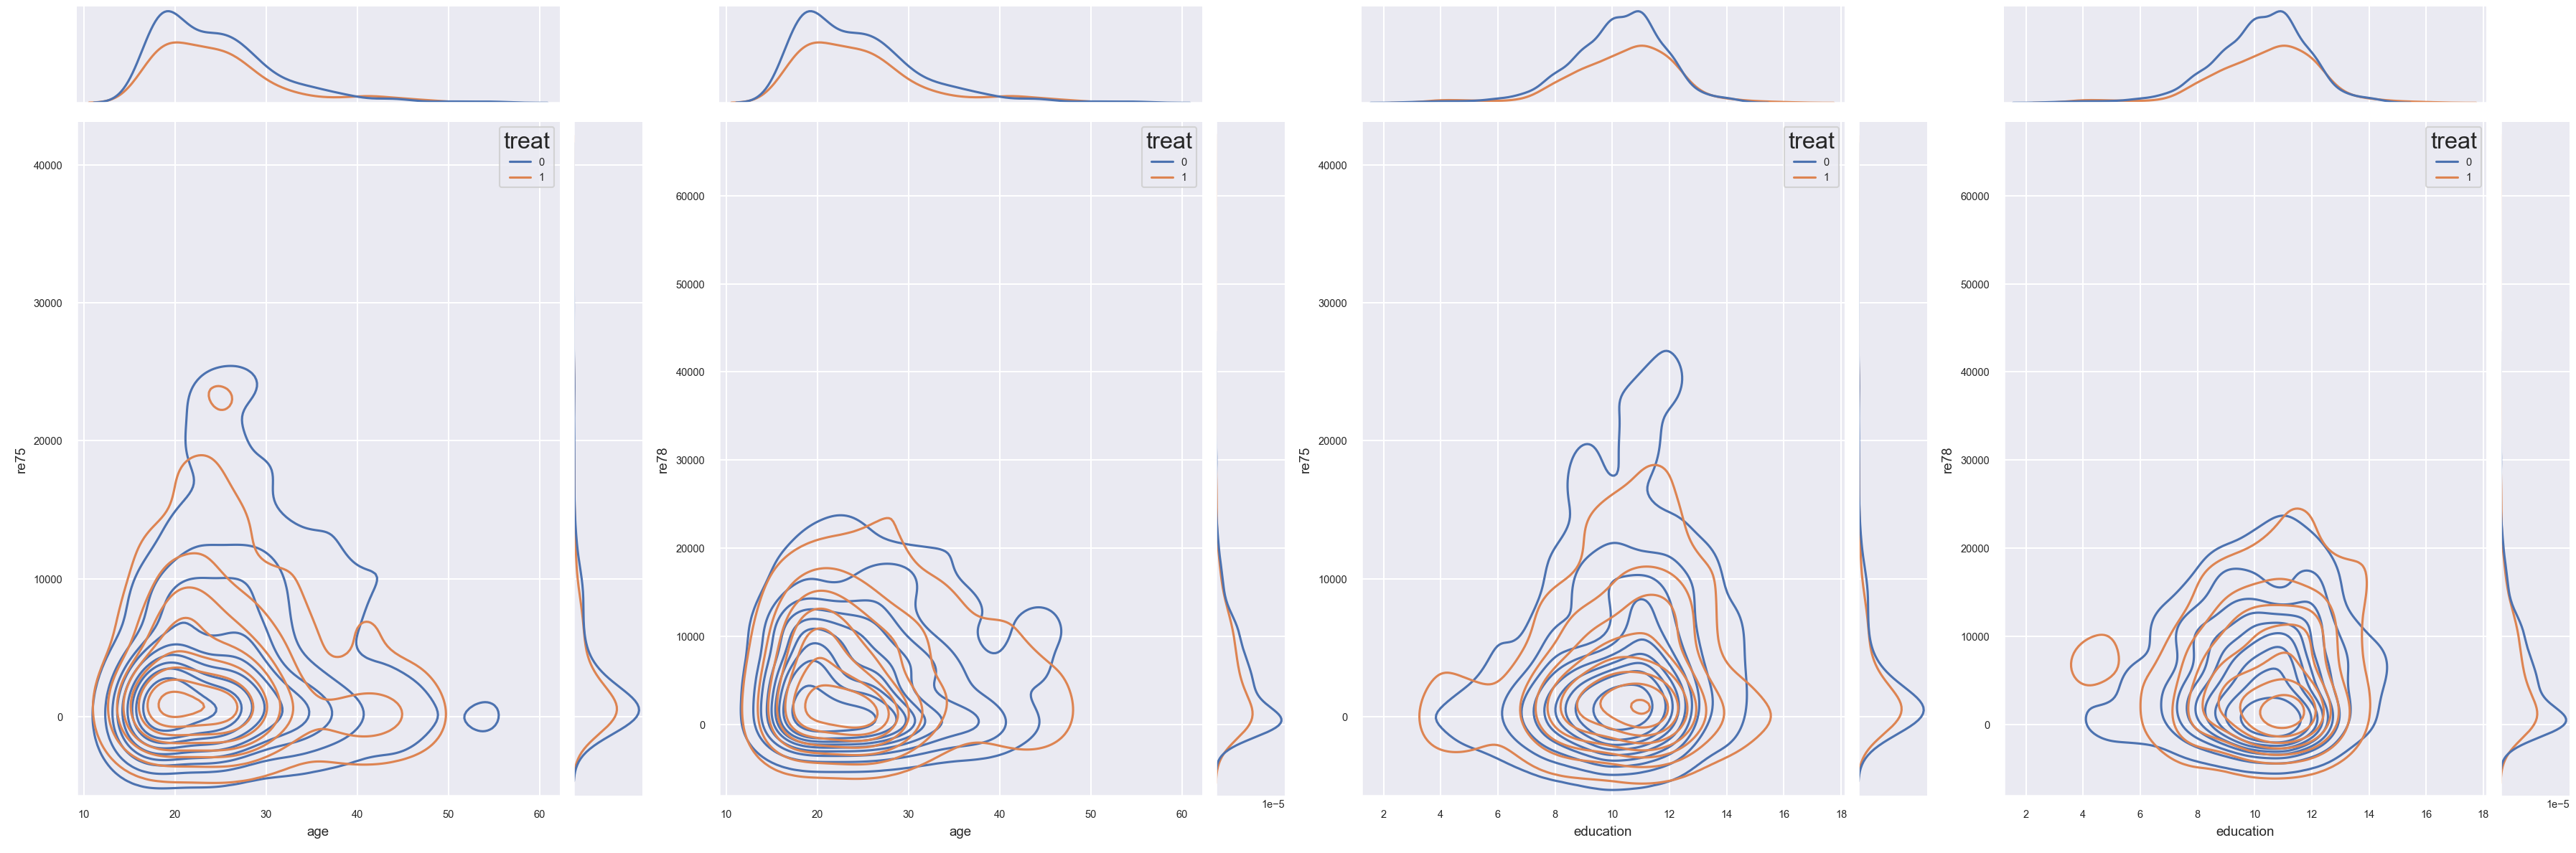

In [568]:
# Joint distributions
sns.set_style('darkgrid')

plot_kind = 'kde'
hue = 'treat'


g0 = sns.jointplot(data= nsw,x="age",y="re75", hue= hue, kind=plot_kind)
g1 = sns.jointplot(data= nsw,x="age",y="re78", hue= hue, kind=plot_kind)
g2 = sns.jointplot(data= nsw,x="education",y="re75", hue= hue, kind=plot_kind)
g3 = sns.jointplot(data= nsw,x="education",y="re78", hue= hue, kind=plot_kind)


fig = plt.figure(figsize=(24,8))
gs = gridspec.GridSpec(1,4)

mg0 = SeabornFigToGrid(g0, fig, gs[0])
mg1 = SeabornFigToGrid(g1, fig, gs[1])
mg2 = SeabornFigToGrid(g2, fig, gs[2])
mg3 = SeabornFigToGrid(g3, fig, gs[3])


gs.tight_layout(fig)


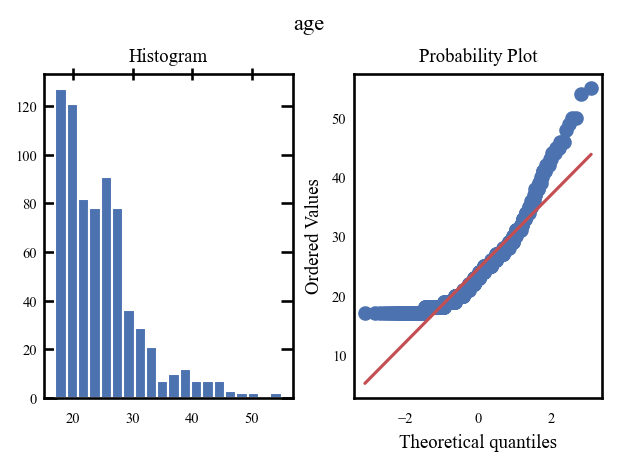

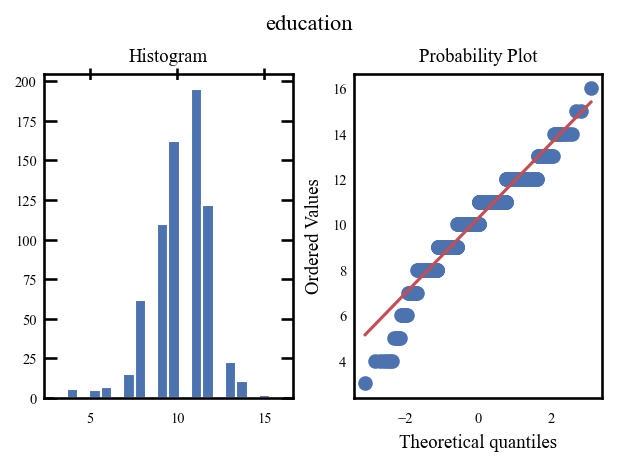

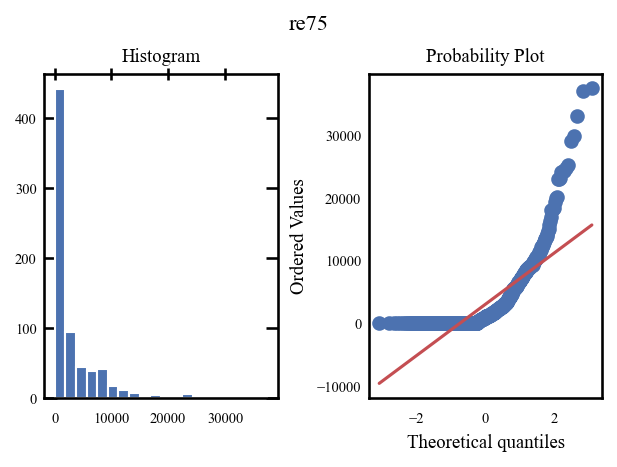

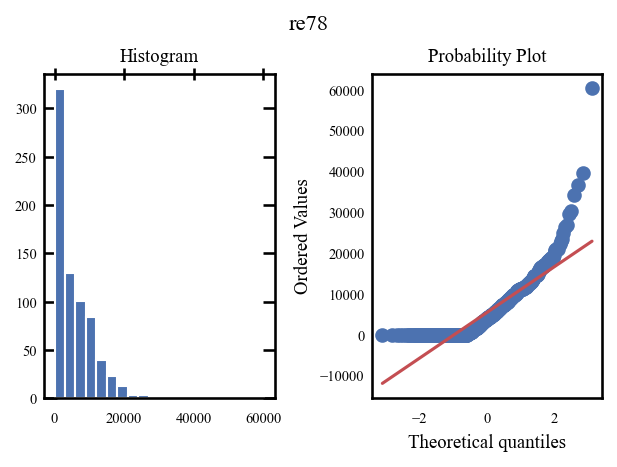

In [569]:
# QQ plots 
# Lalonde
plot_data(nsw,'age',"age")
plot_data(nsw,'education',"education")
plot_data(nsw,'re75',"re75")
plot_data(nsw,'re78',"re78")

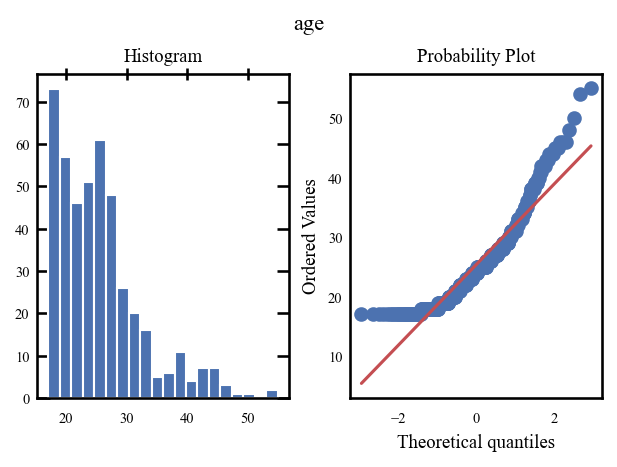

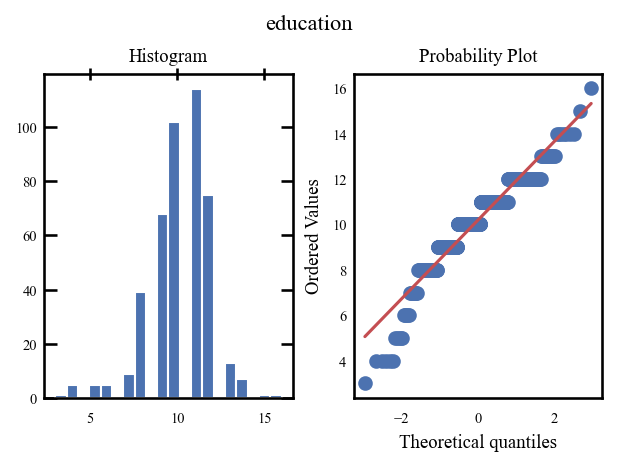

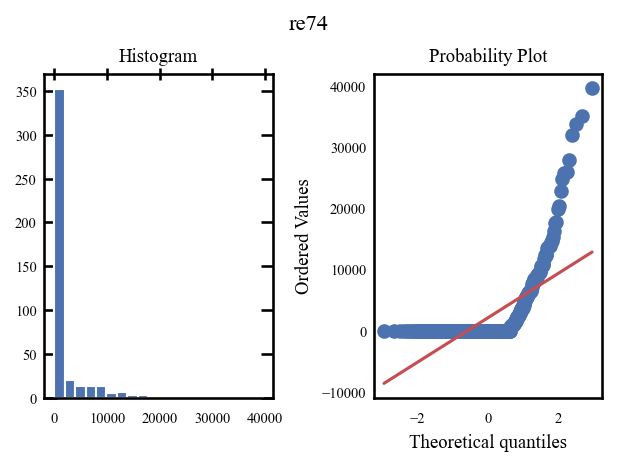

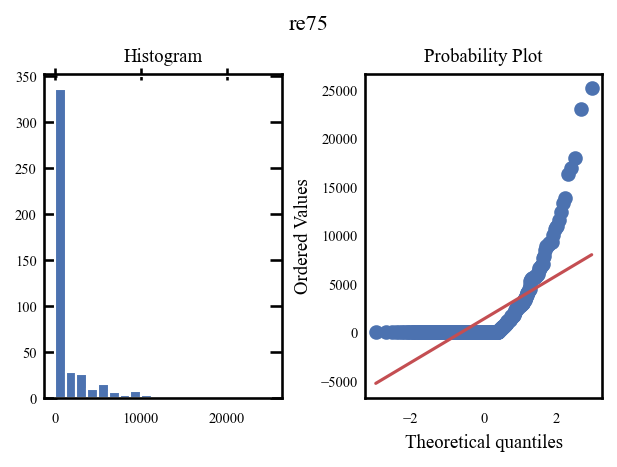

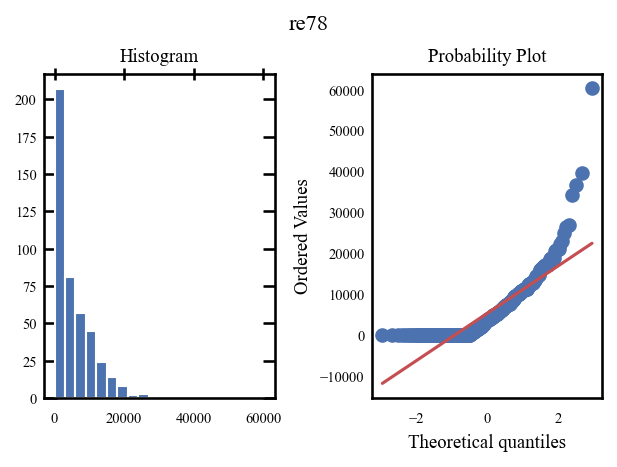

In [570]:
# QQ plots 
# Dehajia Wahba
plot_data(nswre74,'age',"age")
plot_data(nswre74,'education',"education")
plot_data(nswre74,'re74',"re74")
plot_data(nswre74,'re75',"re75")
plot_data(nswre74,'re78',"re78")

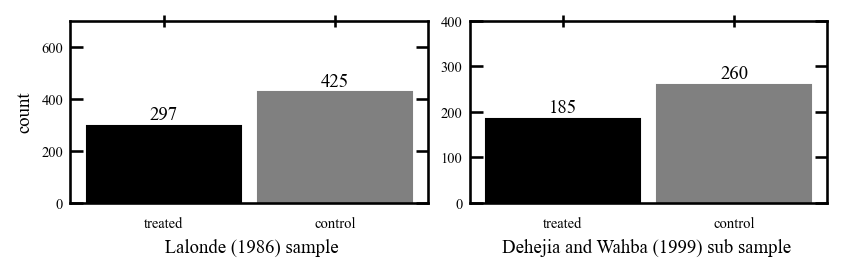

In [571]:
# Plot the balance of classes in the datasets 
#nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw.dta")
#nsw.drop('data_id', axis=1, inplace=True)

#nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
#nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
#nswre74 = pd.concat([nswre74_control,nswre74_treated]) #Combine treatment into a single control as pandas dataframe

from tueplots import axes, bundles , figsizes, fonts,fontsizes

# Lalonde sample 
nswTreated = nsw[nsw['treat']==1]
nswControl = nsw[nsw['treat']==0]
nsw_heights = [len(nswTreated),len(nswControl)]

# Dehejia & Wahba subsample 

nswRe74_Treated = nswre74[nswre74['treat']==1]
nswRe74_Control = nswre74[nswre74['treat']==0]
nswRe74_heights = [len(nswRe74_Treated),len(nswRe74_Control),]

# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=2)


# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
plt.rcParams.update(fontsizes.neurips2022())

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Lalonde sample  bar plot 

# Lalonde sample
ax[0].set_facecolor('white')
ax[0].grid(color='white', axis='y')
ax[0].grid(color='white', axis='x')
ax[0].set_ylim(0,700)

ax[0].spines['left']
ax[0].spines['bottom']
ax[0].spines['top']

ax[0].tick_params(right='on')
ax[0].tick_params(left='on')
ax[0].tick_params(top='on')

ax[0].set_xlabel(" Lalonde (1986) sample")
ax[0].set_ylabel("count")

bar = ax[0].bar(['treated','control'],nsw_heights,width = 0.9)
# colour chart 
bar[1].set_color('grey')
bar[0].set_color('black')

# Add counts to bar chart - lalonde sample 
for rect in ax[0].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[0].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Dehejia & Wahba subsample  bar plot 

ax[1].set_facecolor('white')
ax[1].grid(color='white', axis='y')
ax[1].grid(color='white', axis='x')
ax[1].set_ylim(0,400)

ax[1].spines['left']
ax[1].spines['bottom']
ax[1].spines['top']

bar2 = ax[1].bar(['treated','control'],nswRe74_heights, width = 0.9)

# colour chart 
bar2[1].set_color('grey')
bar2[0].set_color('black')
ax[1].set_xlabel("Dehejia and Wahba (1999) sub sample ")

# tick mark paramaters 
ax[1].tick_params(right='on')
ax[1].tick_params(left='on')
ax[1].tick_params(top='on')


 # Add counts to bar chart - dehejia wahba sample 
for rect in ax[1].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[1].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')   

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Save and display 
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig1_classImbalance_bar_chart.png', bbox_inches='tight')
plt.show()


<p> outliers </p>

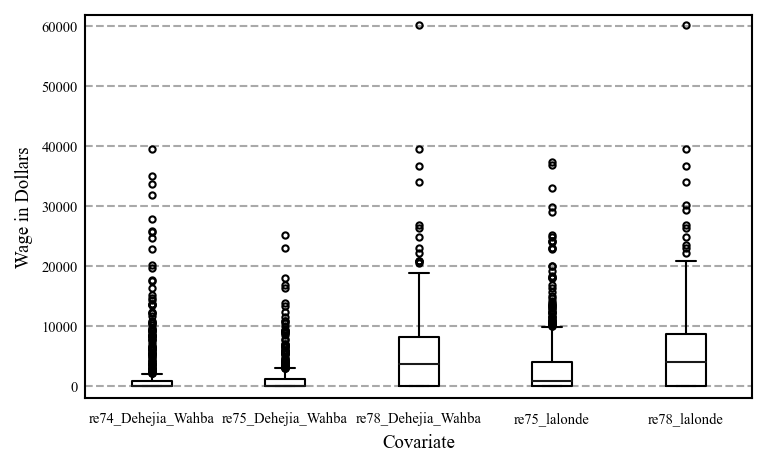

In [572]:
from tueplots import bundles 
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

wage74_dej = nswre74['re74']
wage75_dej = nswre74['re75']
wage78_dej = nswre74['re78']

wage75_lalonde = nsw['re75']
wage78_lalonde = nsw['re78']

ax.boxplot([wage74_dej,wage75_dej,wage78_dej,wage75_lalonde,wage78_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

ax.set_xlim(0.5,5.5)
ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['re74_Dehejia_Wahba', 're75_Dehejia_Wahba','re78_Dehejia_Wahba','re75_lalonde','re78_lalonde'])

ax.set_xlabel('Covariate')
ax.set_ylabel('Wage in Dollars')


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig1_wage_boxplots.png', bbox_inches='tight')
plt.show()

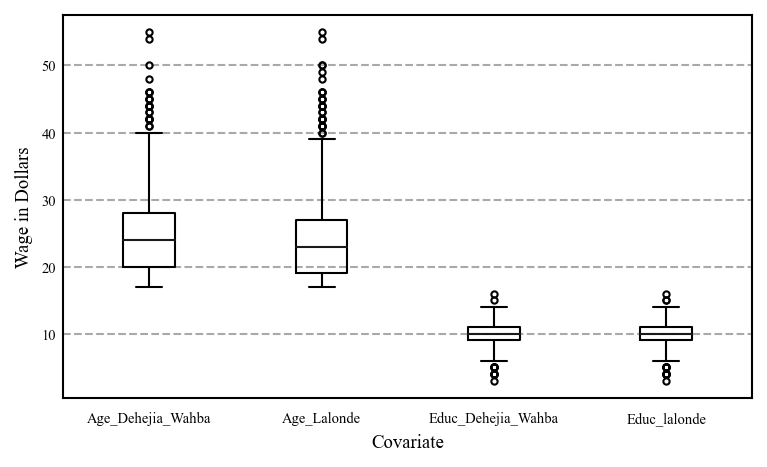

In [573]:
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


Age_dej = nswre74['age']
Educ_dej = nswre74['education']

Age_lalonde = nsw['age']
Educ_lalonde = nsw['education']

ax.boxplot([Age_dej,Age_lalonde,Educ_dej,Educ_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4],['Age_Dehejia_Wahba', 'Age_Lalonde','Educ_Dehejia_Wahba','Educ_lalonde'])


ax.set_xlabel('Covariate')

ax.set_ylabel('Wage in Dollars')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig2_age_educ_boxplots.png', bbox_inches='tight')

plt.show()



<p> Outliers for CPS and PSID </p>

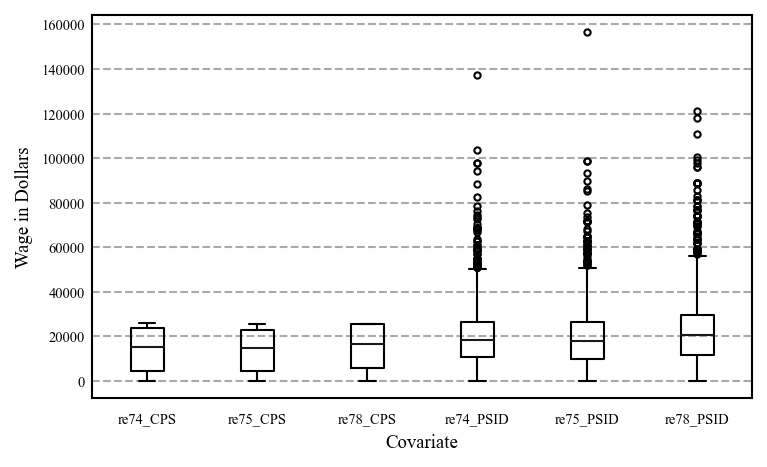

In [574]:
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

wage74_cps = cps1['re74']
wage75_cps = cps1['re75']
wage78_cps = cps1['re78']

wage74_psid = psid1['re74']
wage75_psid = psid1['re75']
wage78_psid = psid1['re78']

ax.boxplot([wage74_cps,wage75_cps,wage78_cps,wage74_psid,wage75_psid,wage78_psid],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5,6],['re74_CPS', 're75_CPS','re78_CPS','re74_PSID','re75_PSID','re78_PSID'])

ax.set_xlabel('Covariate')
ax.set_ylabel('Wage in Dollars')


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/wage_boxplots_cps_psid.png', bbox_inches='tight')
plt.show()

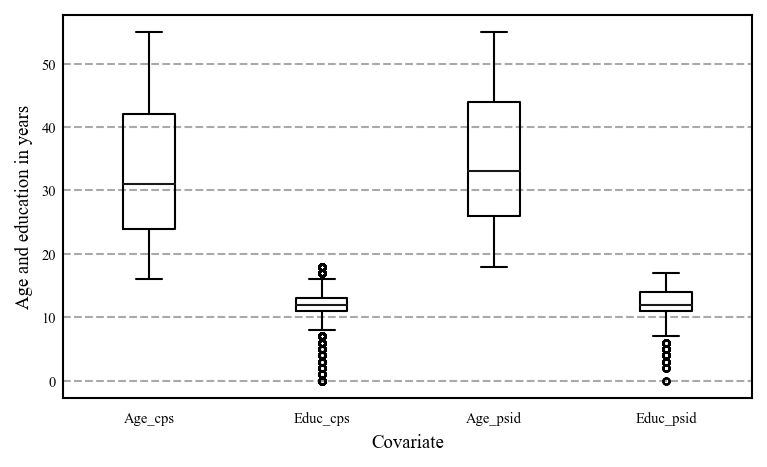

In [575]:
# Age and education 

fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


Age_cps = cps1['age']
Educ_cps = cps1['education']

Age_psid = psid1['age']
Educ_psid = psid1['education']

ax.boxplot([Age_cps,Educ_cps,Age_psid,Educ_psid],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4],['Age_cps', 'Educ_cps','Age_psid','Educ_psid'])

ax.set_xlabel('Covariate')

ax.set_ylabel('Age and education in years')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/age_educ_cpspsid_boxplots.png', bbox_inches='tight')

plt.show()

### Remove outliers, transform variables and store dataset

In [576]:
# Drop outliers 

cols = ['re75','re78','age','education'] 
cols2 = ['re74','re75','re78','age','education'] 

lower_bound = 0.5
upper_bound = 0.95

Q1_1 = nsw[cols].quantile(lower_bound)
Q3_1 = nsw[cols].quantile(upper_bound)
IQR_1 = Q3_1 - Q1_1

Q1_2 = nswre74[cols2].quantile(lower_bound)
Q3_2 = nswre74[cols2].quantile(upper_bound)
IQR_2 = Q3_2 - Q1_2

Q1_3 = cps1[cols2].quantile(lower_bound)
Q3_3 = cps1[cols2].quantile(upper_bound)
IQR_3 = Q3_3 - Q1_3

Q1_4 = psid1[cols2].quantile(lower_bound)
Q3_4 = psid1[cols2].quantile(upper_bound)
IQR_4 = Q3_4 - Q1_4

nsw = nsw[~((nsw[cols] < (Q1_1 -  IQR_1)) |(nsw[cols] > (Q3_1 +  IQR_1))).any(axis=1)]

nswre74 = nswre74[~((nswre74[cols2] < (Q1_2 -  IQR_2)) |(nswre74[cols2] > (Q3_2 +  IQR_2))).any(axis=1)]

cps1 = cps1[~((cps1[cols] < (Q1_3 - IQR_3)) |(cps1[cols2] > (Q3_3 +  IQR_3))).any(axis=1)]
psid1 = psid1[~((psid1[cols2] < (Q1_4 - IQR_4)) |(psid1[cols2] > (Q3_4 + IQR_4))).any(axis=1)]

In [577]:
# Define function for feature transformation 
def feature_tranform(dataset):
    # account for integer overflow - convert features will tranform to 64bit type integer
    dataset['re74'] = dataset['re74'].astype(int)  
    dataset['re75'] = dataset['re75'].astype(int)
    dataset['re78'] = dataset['re78'].astype(int)
    dataset['age'] = dataset['age'].astype(int)
    dataset['education'] = dataset['education'].astype(int) 
    warnings.filterwarnings('ignore')
    # Generate dummy variables 
    dataset['u74'] = (dataset['re74'] == 0).astype('int')
    dataset['u75'] = (dataset['re75'] == 0).astype('int')
    # Generate interaction terms 
    dataset['educ_re74'] = dataset['education']*dataset['re74']
    dataset['educ_re75'] = dataset['education']*dataset['re75']
    dataset['hisp_u75'] = dataset['hispanic']*dataset['u75']
    dataset['hisp_u74'] = dataset['hispanic']*dataset['u74']
    dataset['black_u75'] = dataset['black']*dataset['u75']
    dataset['black_u74'] = dataset['black']*dataset['u74']
    # Change zeroes to in wage as logs struggle
    dataset['re78'][dataset['re78'] == 0] = 1
    dataset['re75'][dataset['re75'] == 0] = 1
    dataset['re74'][dataset['re74'] == 0] = 1
    # squared variables
    dataset['agesq'] = dataset['age']*dataset['age']
    dataset['re78sq'] = dataset['re78']*dataset['re78']
    dataset['re75sq'] = dataset['re75']*dataset['re75']
    dataset['re74sq'] = dataset['re74']*dataset['re74']
    dataset['educsq'] = dataset['education']*dataset['education']
    # boxcox transforms of varibles
    dataset['ageboxcox'],parameters=stat.boxcox(dataset['age']) 
    dataset['re78boxcox'],parameters=stat.boxcox(dataset['re78'])
    dataset['re75boxcox'],parameters=stat.boxcox(dataset['re75'])
    dataset['re74boxcox'],parameters=stat.boxcox(dataset['re74'])
    # natural log of wage
    dataset['lnre78'] = np.log(dataset['re78'])
    dataset['lnre75'] = np.log(dataset['re75'])
    dataset['lnre74'] = np.log(dataset['re74'])
    return dataset  

In [578]:
# account for integer overflow - change features we manipulate to 64bit type integer  

nsw['re75'] = nsw['re75'].astype(int)
nsw['re78'] = nsw['re78'].astype(int)
nsw['age'] = nsw['age'].astype(int)
nsw['education'] = nsw['education'].astype(int)

nswre74['re74'] = nswre74['re74'].astype(int)
nswre74['re75'] = nswre74['re75'].astype(int)
nswre74['re78'] = nswre74['re78'].astype(int)
nswre74['age'] = nswre74['age'].astype(int)
nswre74['education'] = nswre74['education'].astype(int)

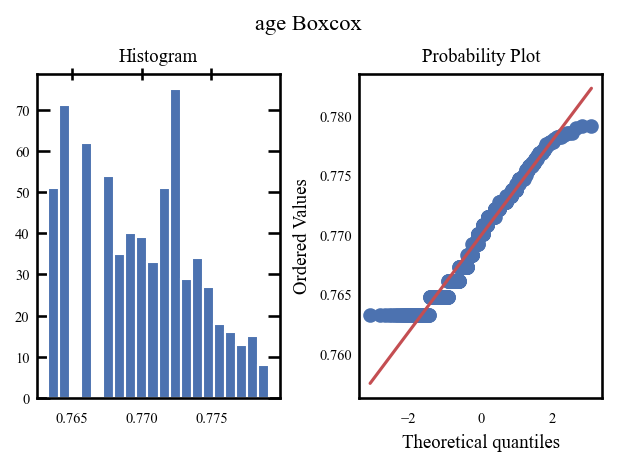

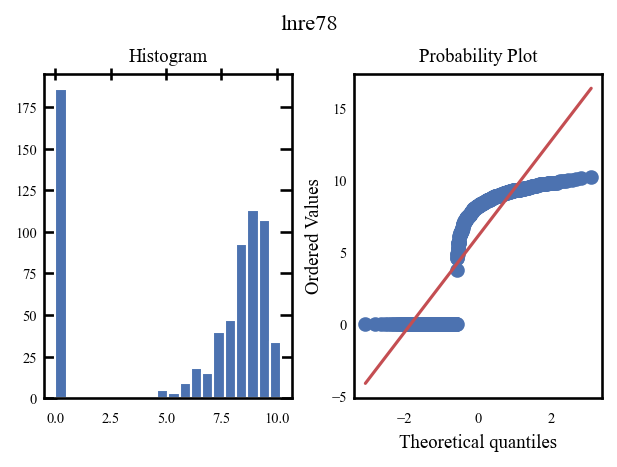

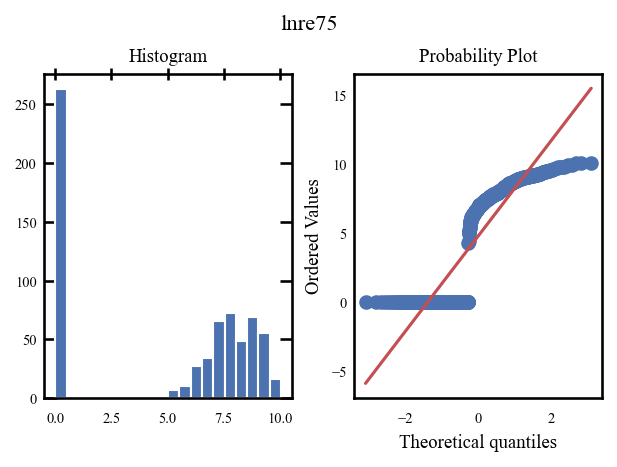

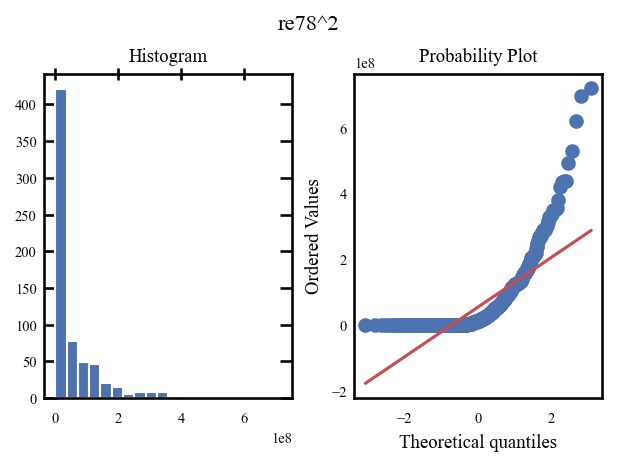

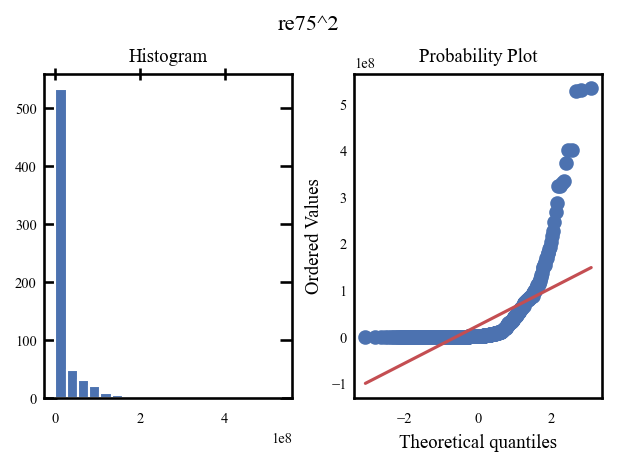

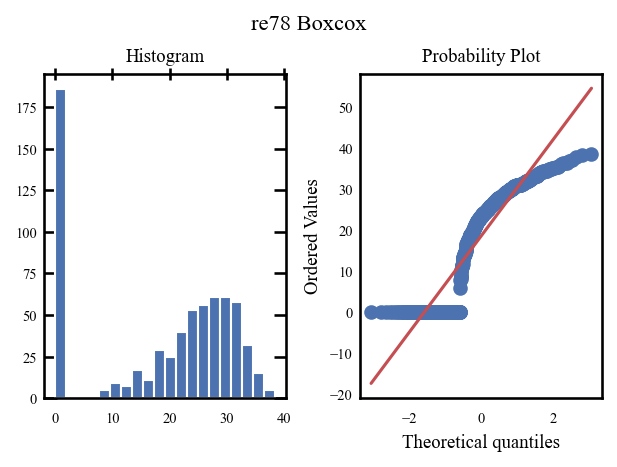

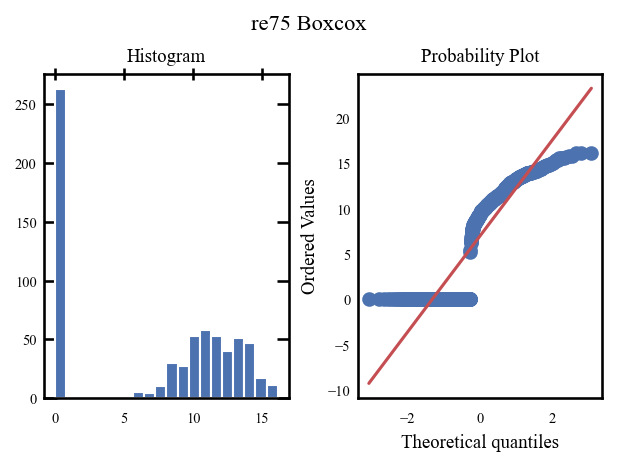

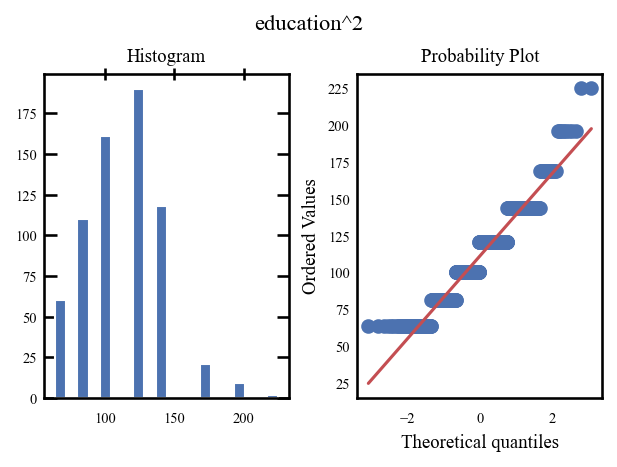

In [579]:
# Transformation of Lalonde original 
warnings.filterwarnings('ignore')

# Generate for unemployed (== 1 if unemployed , == 0 otherwise)
nsw['u75'] = (nsw['re75'] == 0).astype('int')

# Generate interaction terms 
nsw['educ_re75'] = nsw['education']*nsw['re75']
nsw['hisp_u75'] = nsw['hispanic']*nsw['u75']
nsw['black_u75'] = nsw['black']*nsw['u75']


# change 0 to 1 for log transform
nsw['re78'][nsw['re78'] == 0] = 1
nsw['re75'][nsw['re75'] == 0] = 1

nsw['ageboxcox'],parameters=stat.boxcox(nsw['age'])

# Age squared
nsw['agesq'] = nsw['age']*nsw['age']

# boxcox transforms of varibles 
nsw['re78boxcox'],parameters=stat.boxcox(nsw['re78'])
nsw['re75boxcox'],parameters=stat.boxcox(nsw['re75'])

# natural logarith of wages 
nsw['lnre78'] = np.log(nsw['re78'])
nsw['lnre75'] = np.log(nsw['re75'])

#square of wages 
nsw['re78sq'] = nsw['re78']*nsw['re78']
nsw['re75sq'] = nsw['re75']*nsw['re75']

nsw['educsq'] = nsw['education']*nsw['education']


# change back 
nsw['re78'][nsw['re78'] == 1] = 0
nsw['re75'][nsw['re75'] == 1] = 0


# Plot 
plot_data(nsw,'ageboxcox','age Boxcox')

plot_data(nsw,'lnre78','lnre78')
plot_data(nsw,'lnre75','lnre75')

plot_data(nsw,'re78sq','re78^2')
plot_data(nsw,'re75sq','re75^2')

plot_data(nsw,'re78boxcox','re78 Boxcox')
plot_data(nsw,'re75boxcox','re75 Boxcox')

plot_data(nsw,'educsq','education^2')



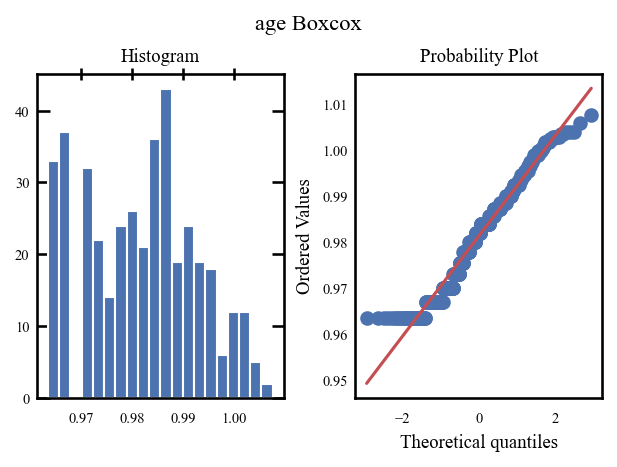

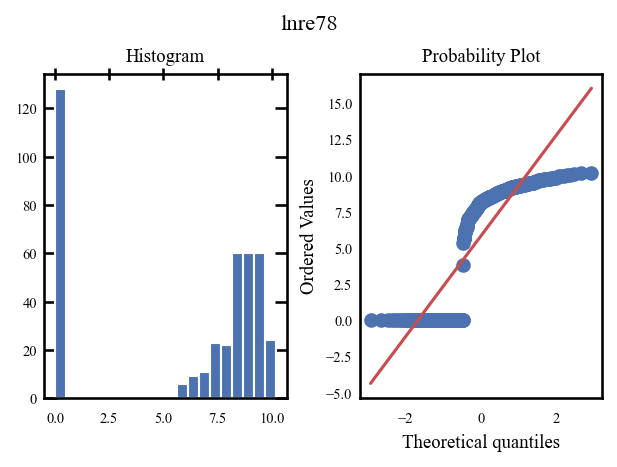

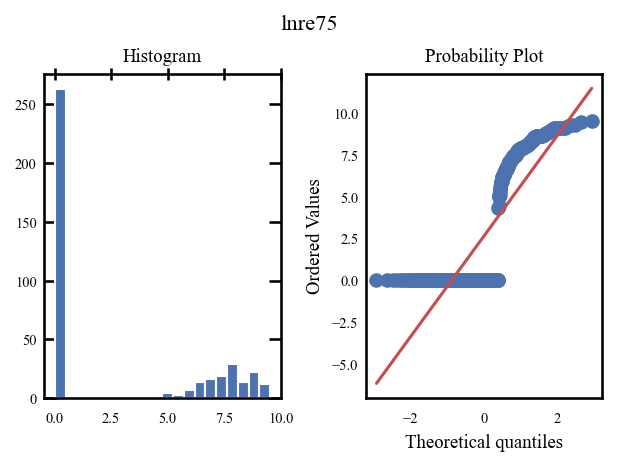

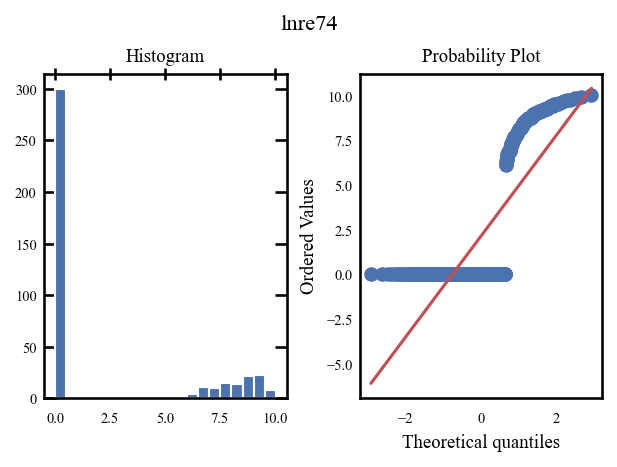

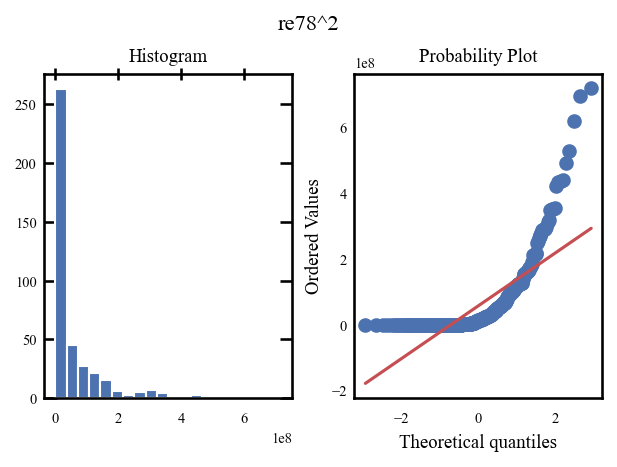

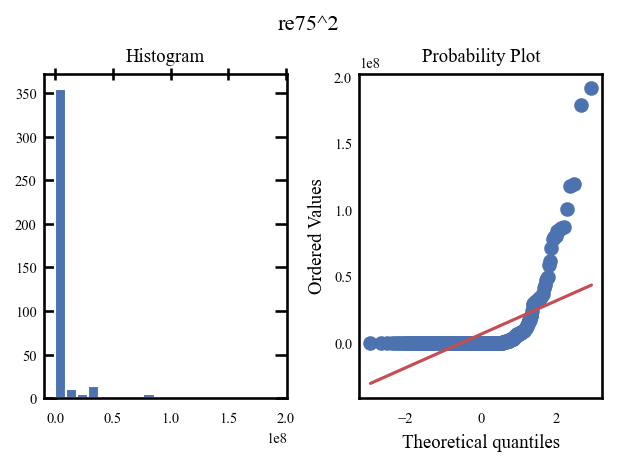

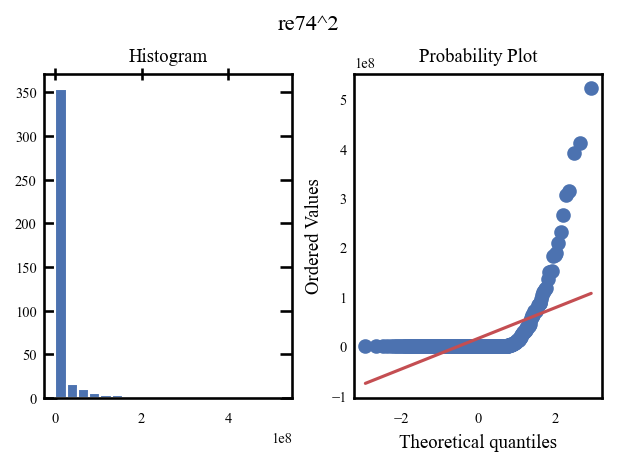

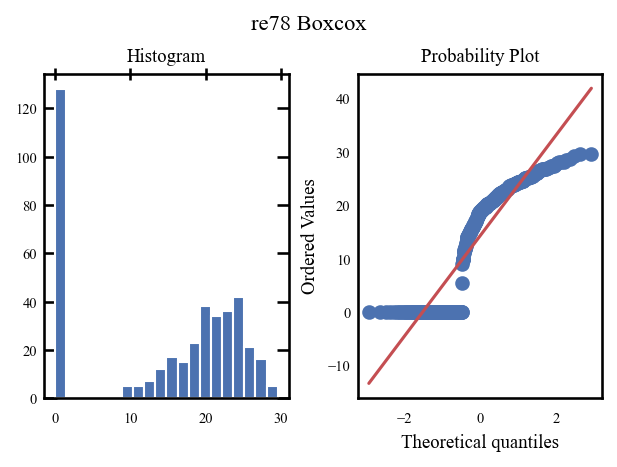

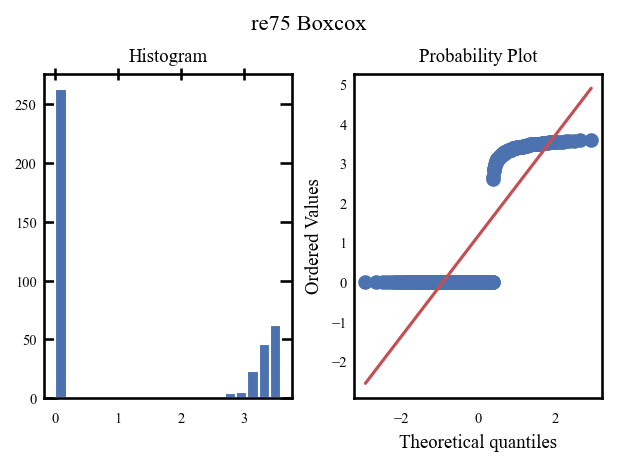

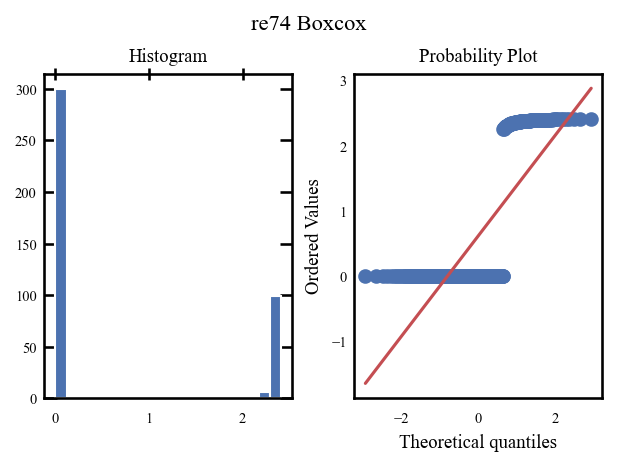

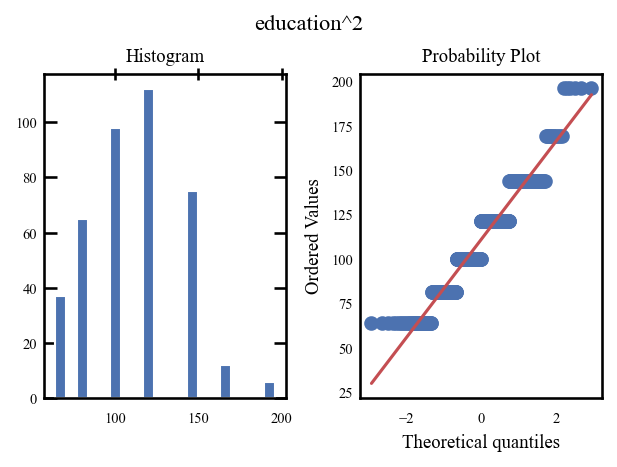

In [580]:
# Transformation of Dehejia Wahba subample
warnings.filterwarnings('ignore')

# Generate dummy variables 

nswre74['u74'] = (nswre74['re74'] == 0).astype('int')
nswre74['u75'] = (nswre74['re75'] == 0).astype('int')

# Generate interaction terms 
nswre74['educ_re74'] = nswre74['education']*nswre74['re74']
nswre74['educ_re75'] = nswre74['education']*nswre74['re75']

nswre74['hisp_u75'] = nswre74['hispanic']*nswre74['u75']
nswre74['hisp_u74'] = nswre74['hispanic']*nswre74['u74']

nswre74['black_u75'] = nswre74['black']*nswre74['u75']
nswre74['black_u74'] = nswre74['black']*nswre74['u74']

# Change zeroes to in wage as logs struggle
nswre74['re78'][nswre74['re78'] == 0] = 1
nswre74['re75'][nswre74['re75'] == 0] = 1
nswre74['re74'][nswre74['re74'] == 0] = 1


nswre74['ageboxcox'],parameters=stat.boxcox(nswre74['age'])

# Age squared
nswre74['agesq'] = nswre74['age']*nswre74['age']

# boxcox transforms of varibles 
nswre74['re78boxcox'],parameters=stat.boxcox(nswre74['re78'])
nswre74['re75boxcox'],parameters=stat.boxcox(nswre74['re75'])
nswre74['re74boxcox'],parameters=stat.boxcox(nswre74['re74'])

# natural logarith of wages 
nswre74['lnre78'] = np.log(nswre74['re78'])
nswre74['lnre75'] = np.log(nswre74['re75'])
nswre74['lnre74'] = np.log(nswre74['re74'])

#square of wages 
nswre74['re78sq'] = nswre74['re78']*nswre74['re78']
nswre74['re75sq'] = nswre74['re75']*nswre74['re75']
nswre74['re74sq'] = nswre74['re74']*nswre74['re74']

nswre74['educsq'] = nswre74['education']*nswre74['education']

# Plot 
plot_data(nswre74,'ageboxcox','age Boxcox')

plot_data(nswre74,'lnre78','lnre78')
plot_data(nswre74,'lnre75','lnre75')
plot_data(nswre74,'lnre74','lnre74')

plot_data(nswre74,'re78sq','re78^2')
plot_data(nswre74,'re75sq','re75^2')
plot_data(nswre74,'re74sq','re74^2')

plot_data(nswre74,'re78boxcox','re78 Boxcox')
plot_data(nswre74,'re75boxcox','re75 Boxcox')
plot_data(nswre74,'re74boxcox','re74 Boxcox')

plot_data(nswre74,'educsq','education^2')



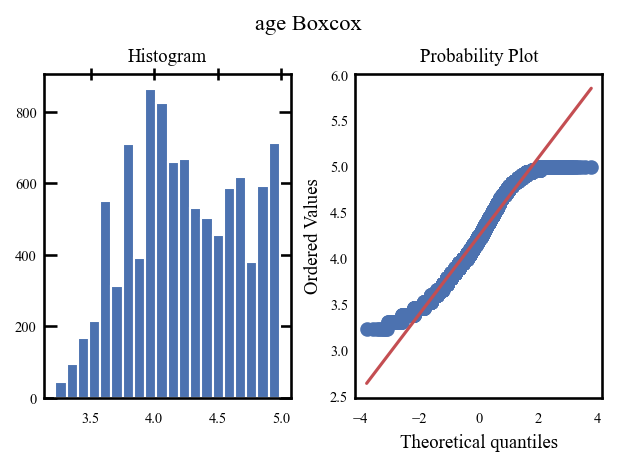

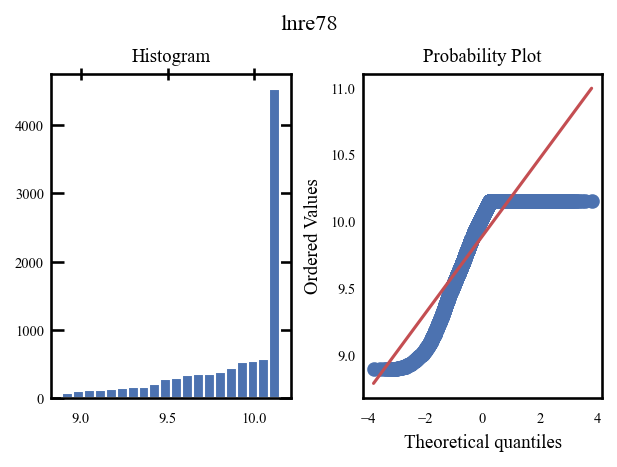

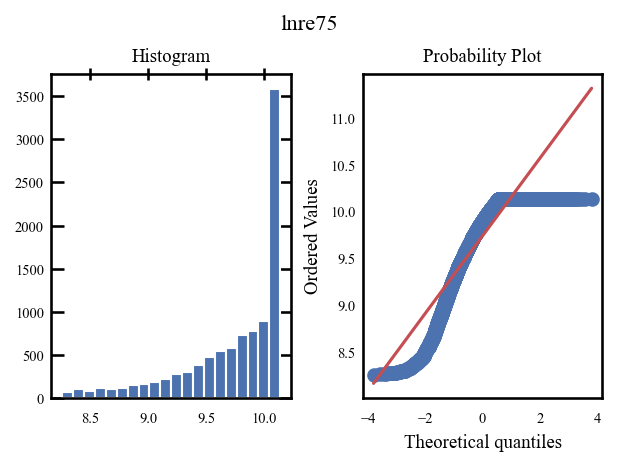

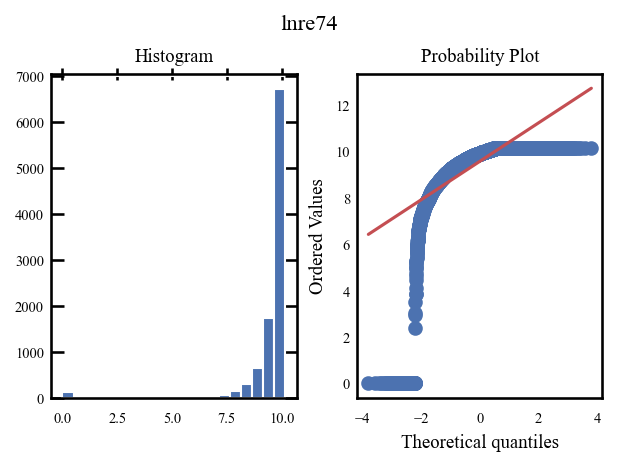

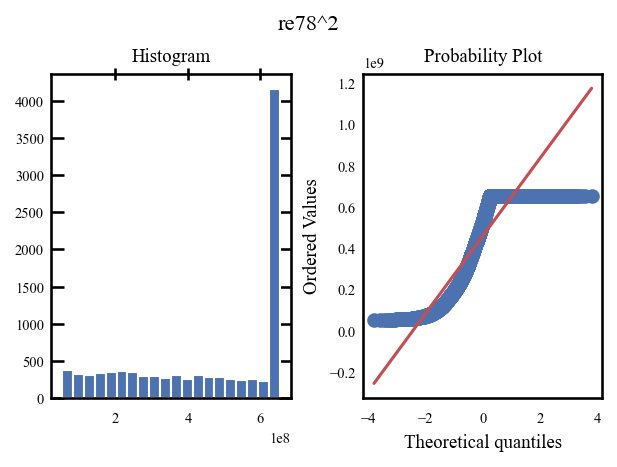

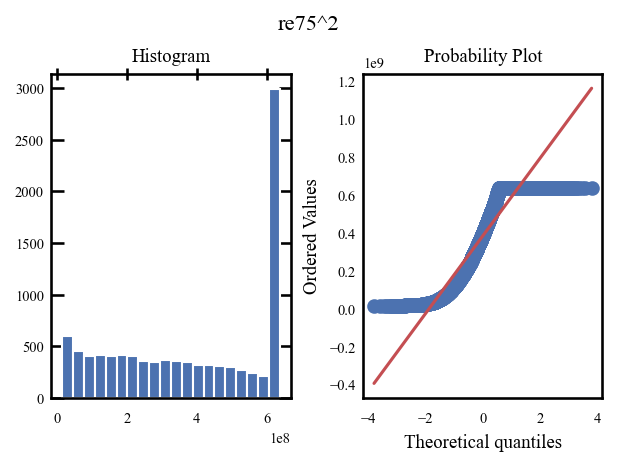

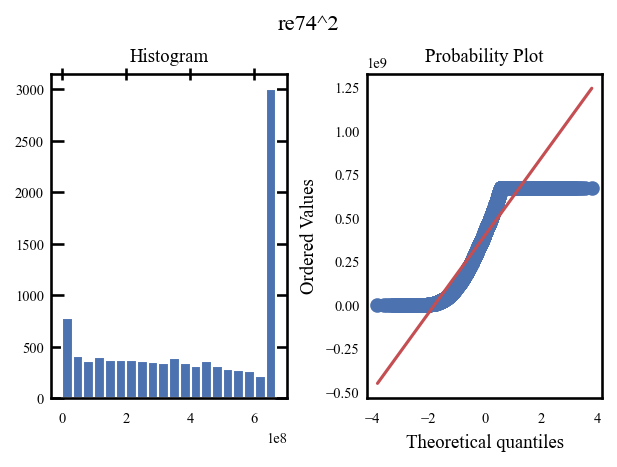

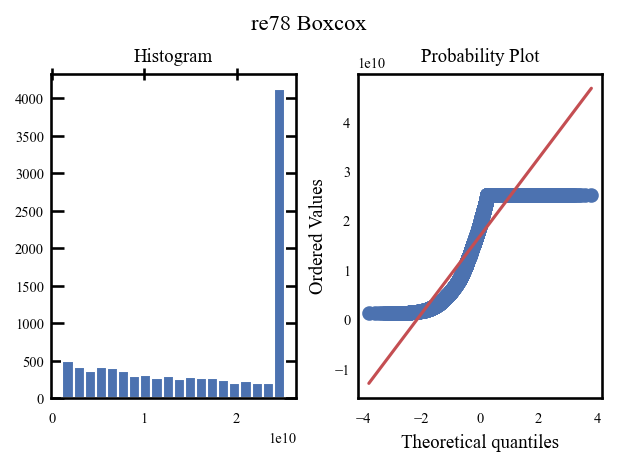

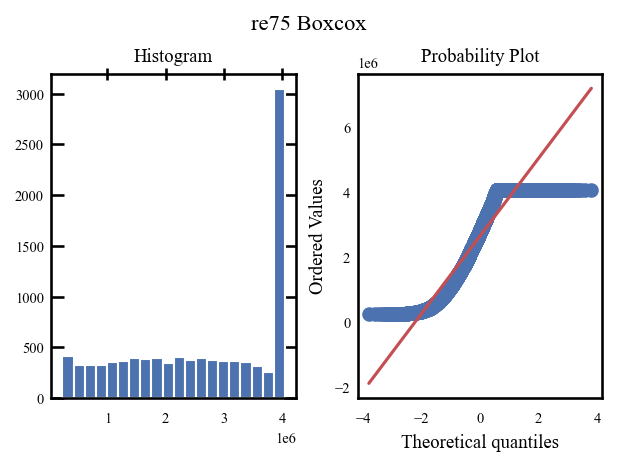

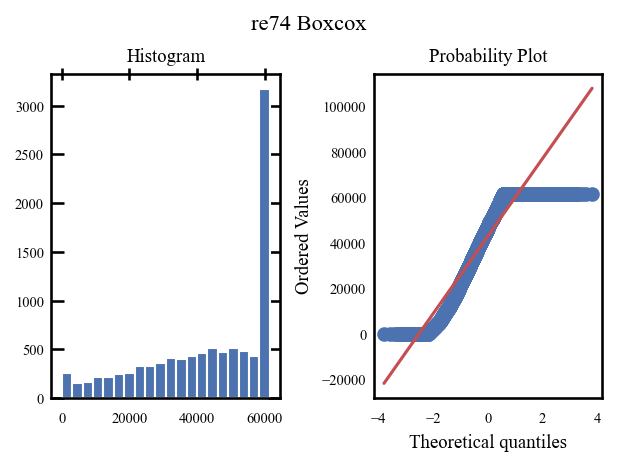

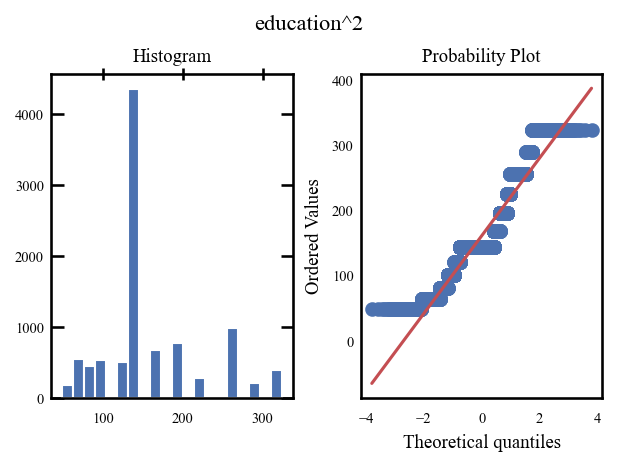

In [581]:
# Transformation of CPS sample
cps1_feature_transformed = feature_tranform(cps1)

# Plot 
plot_data(cps1_feature_transformed,'ageboxcox','age Boxcox')

plot_data(cps1_feature_transformed,'lnre78','lnre78')
plot_data(cps1_feature_transformed,'lnre75','lnre75')
plot_data(cps1_feature_transformed,'lnre74','lnre74')

plot_data(cps1_feature_transformed,'re78sq','re78^2')
plot_data(cps1_feature_transformed,'re75sq','re75^2')
plot_data(cps1_feature_transformed,'re74sq','re74^2')

plot_data(cps1_feature_transformed,'re78boxcox','re78 Boxcox')
plot_data(cps1_feature_transformed,'re75boxcox','re75 Boxcox')
plot_data(cps1_feature_transformed,'re74boxcox','re74 Boxcox')

plot_data(cps1_feature_transformed,'educsq','education^2')

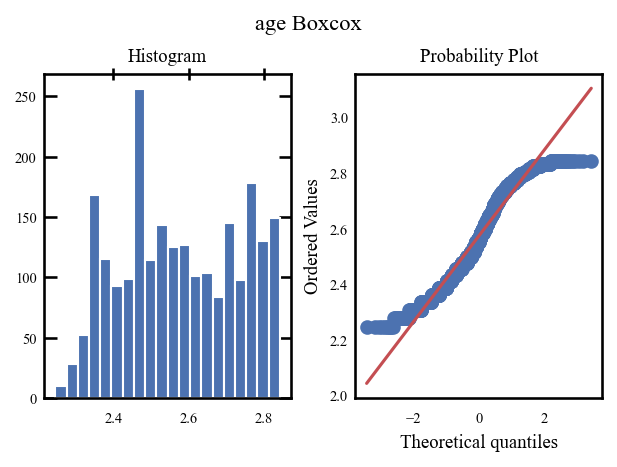

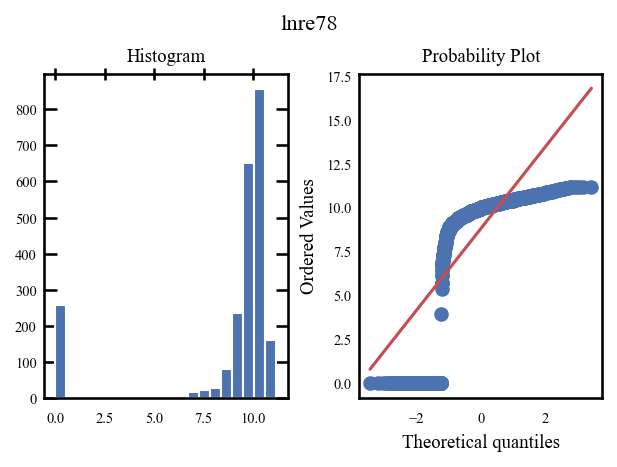

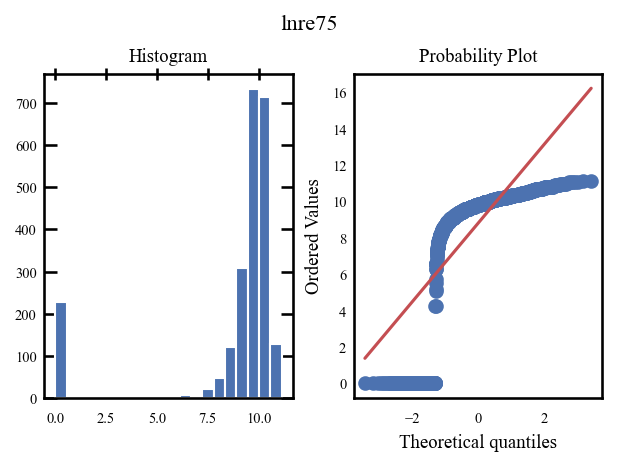

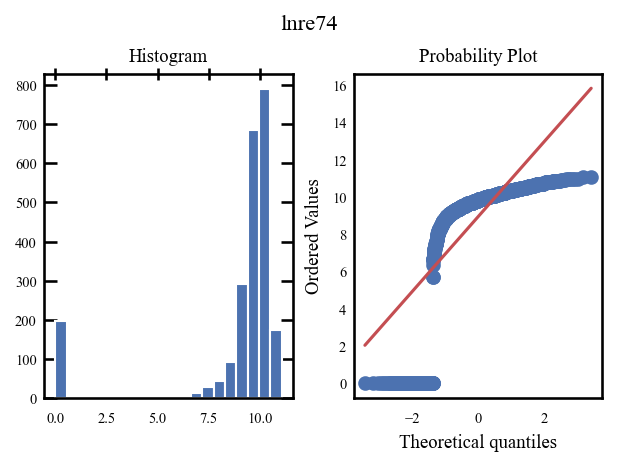

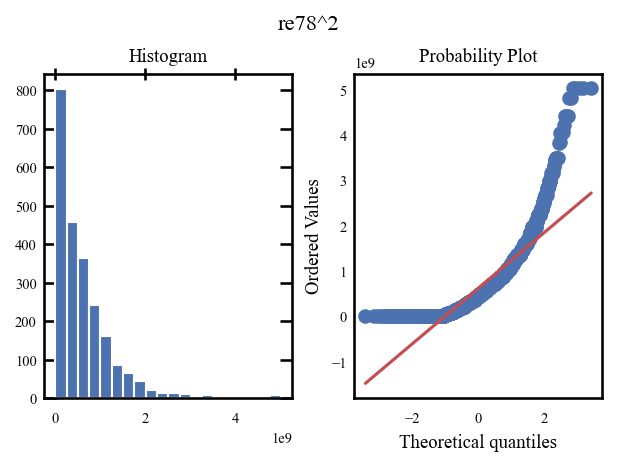

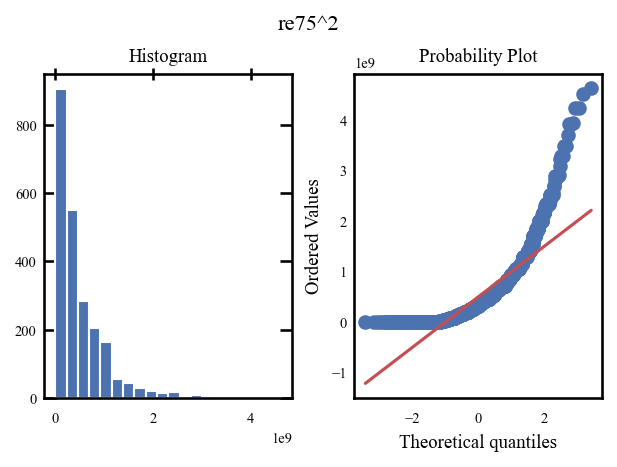

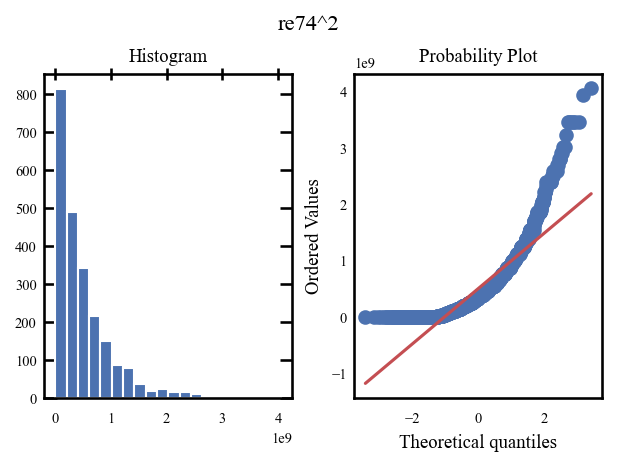

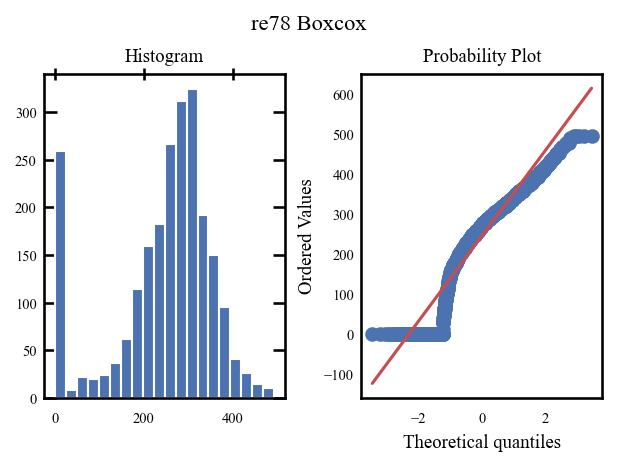

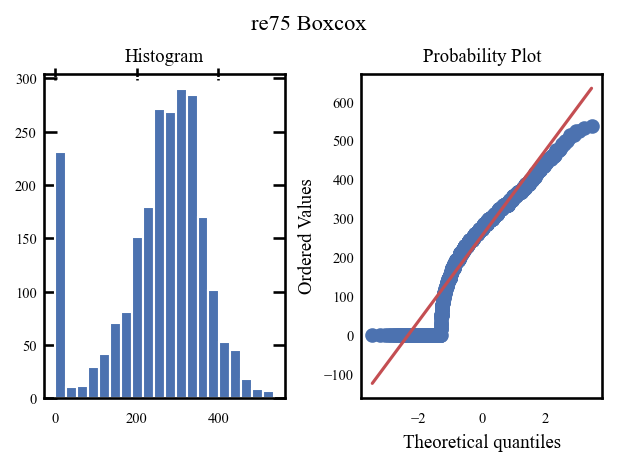

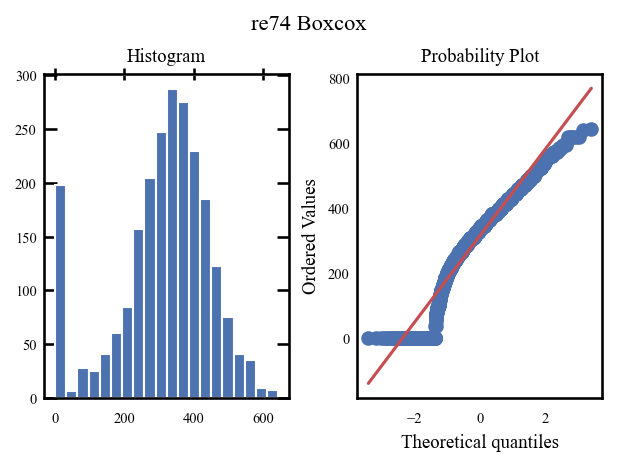

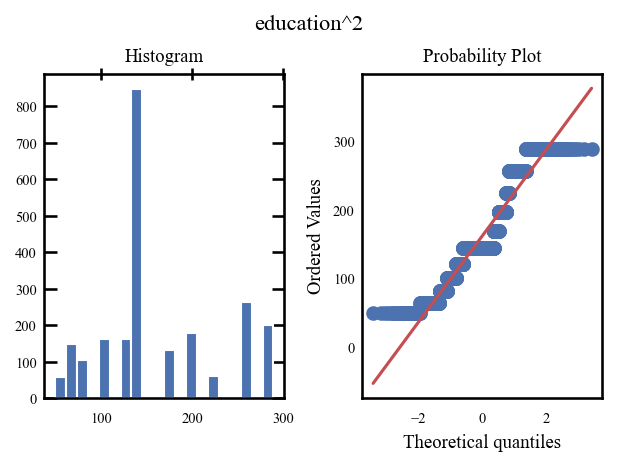

In [582]:
# Transformation of PSID sample
psid_feature_transformed = feature_tranform(psid1)

# Plot 
plot_data(psid_feature_transformed,'ageboxcox','age Boxcox')

plot_data(psid_feature_transformed,'lnre78','lnre78')
plot_data(psid_feature_transformed,'lnre75','lnre75')
plot_data(psid_feature_transformed,'lnre74','lnre74')

plot_data(psid_feature_transformed,'re78sq','re78^2')
plot_data(psid_feature_transformed,'re75sq','re75^2')
plot_data(psid_feature_transformed,'re74sq','re74^2')

plot_data(psid_feature_transformed,'re78boxcox','re78 Boxcox')
plot_data(psid_feature_transformed,'re75boxcox','re75 Boxcox')
plot_data(psid_feature_transformed,'re74boxcox','re74 Boxcox')

plot_data(psid_feature_transformed,'educsq','education^2')

### Key points 
<p> 1. Taking logs of wage reveals that the distribution is bimodal </p>
<p> ---- There are a group of low wage earners (o mode) and higher wave earns (around 8 mode) </p>
<p> ---- Treatment decreases amount of low wage earns, increases amount of high wave earners</p>

### Save datasets

In [583]:
#nsw.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw_featureTransformed.csv',header = True,index = False)
#nswre74.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_featureTransformed.csv',header = True,index = False)
#cps1.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_featureTransformed.csv',header = True,index = False)
#psid1.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_featureTransformed.csv',header = True,index = False)

# Propensity score estimation and matching

In [632]:
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

### model (1) Logistic Regression 

In [648]:
# Load dataset for matching 
nsw_transformed_features = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw_featureTransformed.csv")
nswre74_transformed_features = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_featureTransformed.csv")
cps1_transformed_features = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_featureTransformed.csv')
psid1_transformed_features = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_featureTransformed.csv')

In [649]:
# Import libraries for LR
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.api as sm

In [650]:
# Select a subset of variables for model 
LALONDE_subset1 = ['treat','age','agesq','education','educsq','black','hispanic','married','nodegree','re75','u75']
LALONDE_subset2 = ['treat','age','agesq','education','educsq','black','hispanic','married','nodegree','re75','u75','educ_re75']
LALONDE_subset3 = ['treat','age','agesq','education','educsq','black','hispanic','married','nodegree','re75','re78','u75']

DW_subset1 = ['treat','age','agesq','education','educsq','black','hispanic','married','nodegree','re74','lnre75','u75','u74']
DW_subset2 = ['treat','age','agesq','education','educsq','black','hispanic','married','nodegree','re74','lnre75','u75','u74','educ_re74']
DW_subset3 = ['treat','age','agesq','education','educsq','black','hispanic','married','nodegree','re74','lnre75','u75','u74','educ_re74','hisp_u74','black_u74']

nsw_outcome = nsw_transformed_features[nsw_transformed_features['treat']==1].re78
nsw_re74_outcome = nswre74_transformed_features.re78
cps1_outcome = cps1_transformed_features.re78
psid1_outcome = psid1_transformed_features.re78

nsw_transformed_features = nsw_transformed_features[LALONDE_subset1]
nswre74_transformed_features = nswre74_transformed_features[DW_subset2]


In [651]:
print(nsw_transformed_features.index,nsw_outcome.index)

RangeIndex(start=0, stop=671, step=1) Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            267, 268, 269, 270, 271, 272, 273, 274, 275, 276],
           dtype='int64', length=277)


In [652]:
cps1_transformed_features = cps1_transformed_features[LALONDE_subset1]
psid1_transformed_features = psid1_transformed_features[LALONDE_subset1]


In [653]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

# ======== Lalonde (1986) sample ======== #

# Shuffle data 
nsw_transformed_features = nsw_transformed_features.sample(frac = 1,random_state=0)
#nsw_transformed_features = nsw_transformed_features.reset_index(drop=True)
# Define features and target 
FEATURES = nsw_transformed_features.drop('treat', axis=1)
TARGET = nsw_transformed_features.iloc[:,0]
# Train test split 
FEATURES_train, FEATURES_test, TARGET_train, TARGET_test = train_test_split(FEATURES, TARGET, test_size=0.3, random_state=42) 

#nsw_transformed_features = nsw_transformed_features.drop('treat', axis=1)
# ======== Dehejia & Wahba (1999) sub sample ======== #

# Shuffle data 
nswre74_transformed_features = nswre74_transformed_features.sample(frac = 1,random_state=0)
#nswre74_transformed_features = nswre74_transformed_features.reset_index(drop=True)
 
# Define features and target 
FEATURES_DW = nswre74_transformed_features.drop('treat', axis=1)
TARGET_DW = nswre74_transformed_features.iloc[:,0]

# Train test split 
FEATURES_DW_train, FEATURES_DW_test, TARGET_DW_train, TARGET_DW_test = train_test_split(FEATURES_DW, TARGET_DW, test_size=0.3, random_state=42) 
#nswre74_transformed_features = nswre74_transformed_features.drop('treat', axis=1)


In [654]:
# Fit Logistic Regression using sklearn
model1 = LogisticRegression()
model2 = LogisticRegression()
# ======== Lalonde (1986) sample ======== #
model1.fit(FEATURES_train,TARGET_train)
y_pred= model1.predict(FEATURES_test)
# ======== Dehejia & Wahba (1999) sub sample ======== #
model2.fit(FEATURES_DW_train,TARGET_DW_train)
y_pred_dw = model2.predict(FEATURES_DW_test)

In [655]:
# Model metrics
# ======== Lalonde (1986) sample ======== #
print("Accuracy (lalonde sample):",metrics.accuracy_score(TARGET_test, y_pred))
print("Precision (lalonde sample):",metrics.precision_score(TARGET_test, y_pred))
print("Recall (lalonde sample):",metrics.recall_score(TARGET_test, y_pred))
print("MSE (lalonde sample):",metrics.mean_squared_error(TARGET_test, y_pred))
print("F1 (lalonde sample):",metrics.f1_score(TARGET_test, y_pred))
print('================')

# ======== Dehejia & Wahba (1999) sub sample ======== #
print("Accuracy (DW sample):",metrics.accuracy_score(TARGET_DW_test, y_pred_dw))
print("Precision (DW sample):",metrics.precision_score(TARGET_DW_test, y_pred_dw))
print("Recall (DW sample):",metrics.recall_score(TARGET_DW_test, y_pred_dw))
print("MSE (DW sample):",metrics.mean_squared_error(TARGET_DW_test, y_pred_dw))
print("F1 (DW sample):",metrics.f1_score(TARGET_DW_test, y_pred_dw))

Accuracy (lalonde sample): 0.5544554455445545
Precision (lalonde sample): 0.3225806451612903
Recall (lalonde sample): 0.12658227848101267
MSE (lalonde sample): 0.44554455445544555
F1 (lalonde sample): 0.18181818181818182
Accuracy (DW sample): 0.5573770491803278
Precision (DW sample): 0.40476190476190477
Recall (DW sample): 0.3695652173913043
MSE (DW sample): 0.4426229508196721
F1 (DW sample): 0.38636363636363635


In [656]:
# ======== Lalonde (1986) sample ======== #
# Regression coefficients 
import statsmodels.api as sm
logit_model1 =sm.Logit(TARGET_train,FEATURES_train)
result1=logit_model1.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.664276
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  469
Model:                          Logit   Df Residuals:                      459
Method:                           MLE   Df Model:                            9
Date:                Tue, 09 Aug 2022   Pseudo R-squ.:                 0.02453
Time:                        21:54:46   Log-Likelihood:                -311.55
converged:                       True   LL-Null:                       -319.38
Covariance Type:            nonrobust   LLR p-value:                   0.07406
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0391      0.098      0.398      0.690      -0.153       0.231
agesq         -0.0005      0.

In [657]:
# ======== Dehejia & Wahba (1999) sub sample ======== #
logit_model2=sm.Logit(TARGET_DW,FEATURES_DW)
result2=logit_model2.fit()
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.658399
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  405
Model:                          Logit   Df Residuals:                      392
Method:                           MLE   Df Model:                           12
Date:                Tue, 09 Aug 2022   Pseudo R-squ.:                 0.02848
Time:                        21:54:46   Log-Likelihood:                -266.65
converged:                       True   LL-Null:                       -274.47
Covariance Type:            nonrobust   LLR p-value:                    0.2085
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0330      0.097      0.340      0.734      -0.157       0.223
agesq         -0.0004      0.

In [658]:
# function that returns dataset with propensity scores and propensity logits from logistic regression
def propensity_score_funct(dataset,model):
    # Generate propensity score prediction 
    probabilities = model.predict_proba(dataset.drop('treat', axis=1))
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1] # propensity score 
    # merge prediction and existing dataset 
    dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [662]:
# Predict propensity scores on NSW , CPS and PSID 

nsw_ps_logitmodel = propensity_score_funct(nsw_transformed_features,model1)
nsw_treatedUnits_ps_logitmodel = nsw_ps_logitmodel[nsw_ps_logitmodel['treat'] == 1] # drop control units from lalonde dataset 
cps_ps_logitmodel = propensity_score_funct(cps1_transformed_features,model1)
psid1_ps_logitmodel = propensity_score_funct(psid1_transformed_features,model1)

# Rejoin the outcome variable to dataframe with estimated propensity scores 

nsw_treatedUnits_ps_logitmodel_full = pd.merge(nsw_treatedUnits_ps_logitmodel, nsw_outcome, left_index=True, right_index=True)
cps_ps_logitmodel_full = pd.merge(cps_ps_logitmodel,cps1_outcome,left_index=True, right_index=True)
psid_ps_logitmodel_full = pd.merge(psid1_ps_logitmodel,psid1_outcome,left_index=True, right_index=True)

# Combine treated units with control units 
nsw_cps_ps = pd.concat([nsw_treatedUnits_ps_logitmodel_full,cps_ps_logitmodel_full],axis=0, ignore_index = True)
nsw_psid_ps = pd.concat([nsw_treatedUnits_ps_logitmodel_full,psid_ps_logitmodel_full],axis=0, ignore_index = True)


,treat,age,agesq,education,educsq,black,hispanic,married,nodegree,re75,u75,propensity_score,propensity_logit,re78
0,0.0,45,2025,11,121,0.0,0.0,1.0,1.0,25243,0,0.460387,-0.158785,25564
1,0.0,21,441,14,196,0.0,0.0,0.0,0.0,5852,0,0.556482,0.226897,13496
2,0.0,38,1444,12,144,0.0,0.0,1.0,0.0,25130,0,0.593771,0.379576,25564
3,0.0,18,324,8,64,0.0,0.0,1.0,1.0,10727,0,0.456931,-0.172705,9860
4,0.0,22,484,11,121,0.0,0.0,1.0,1.0,18449,0,0.458906,-0.164747,25564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,0.0,27,729,13,169,0.0,0.0,1.0,0.0,25243,0,0.584589,0.341640,25564
9872,0.0,55,3025,9,81,0.0,0.0,1.0,1.0,25243,0,0.376834,-0.503009,21463
9873,0.0,48,2304,10,100,0.0,0.0,1.0,1.0,25243,0,0.443003,-0.228982,25564
9874,0.0,47,2209,9,81,0.0,0.0,1.0,1.0,11384,0,0.468349,-0.126774,13671


In [663]:
from causalml.match import NearestNeighborMatch, create_table_one

caliper = np.std(nsw_cps_ps.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 

# NSW and CPS comparison group 
nsw_cps_ps_matched = psm.match(nsw_cps_ps,'treat',['propensity_score'])
nsw_cps_ps_pre_matched = pd.concat([nsw_treatedUnits_ps_logitmodel_full,cps_ps_logitmodel_full],axis=0,ignore_index=True)

# NSW and PSID comparison group 
nsw_psid_ps_matched = psm.match(nsw_psid_ps,'treat',['propensity_score'])
nsw_psid_ps_pre_matched = pd.concat([nsw_treatedUnits_ps_logitmodel_full,psid_ps_logitmodel_full],axis=0,ignore_index=True) # comparison before matchibg 

,treat,age,agesq,education,educsq,black,hispanic,married,nodegree,re75,u75,propensity_score,propensity_logit,re78
30,1.0,25,625,10,100,1.0,0.0,0.0,1.0,0,1,0.601949,0.413594,0
126,1.0,21,441,12,144,0.0,0.0,0.0,0.0,334,0,0.434797,-0.262307,12558
220,1.0,41,1681,14,196,0.0,0.0,0.0,0.0,0,1,0.406100,-0.380110,5149
255,1.0,17,289,10,100,1.0,0.0,0.0,1.0,156,0,0.476028,-0.095960,10641
97,1.0,21,441,9,81,1.0,0.0,0.0,1.0,0,1,0.469561,-0.121905,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,0.0,53,2809,8,64,0.0,0.0,1.0,1.0,21720,0,0.415290,-0.342139,25564
7562,0.0,55,3025,10,100,0.0,0.0,1.0,1.0,13527,0,0.373507,-0.517203,14936
1861,0.0,46,2116,8,64,0.0,0.0,1.0,1.0,18046,0,0.485711,-0.057173,20284
5396,0.0,18,324,11,121,1.0,0.0,0.0,1.0,4139,0,0.398948,-0.409849,8372


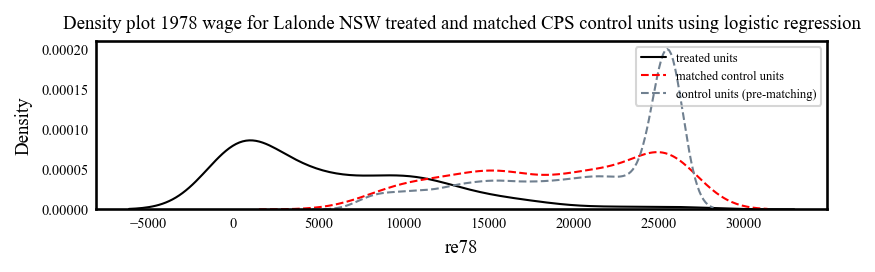

In [672]:
plt.figure()
plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in",x = "in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022())
plt.rcParams.update(fontsizes.neurips2022())

plt.grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
plt.grid(color='white', axis='x')

# Density plots post-matching
sns.kdeplot(nsw_cps_ps_matched['re78'][nsw_cps_ps_matched['treat']==1],color = 'black',linewidth=1,label = 'treated units')
sns.kdeplot(nsw_cps_ps_matched['re78'][nsw_cps_ps_matched['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units')
# Density plots pre-matching
sns.kdeplot(nsw_cps_ps_pre_matched['re78'][nsw_cps_ps_pre_matched['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)')

plt.title('Density plot 1978 wage for Lalonde NSW treated and matched CPS control units using logistic regression')
plt.legend(fontsize=6,loc = 1)

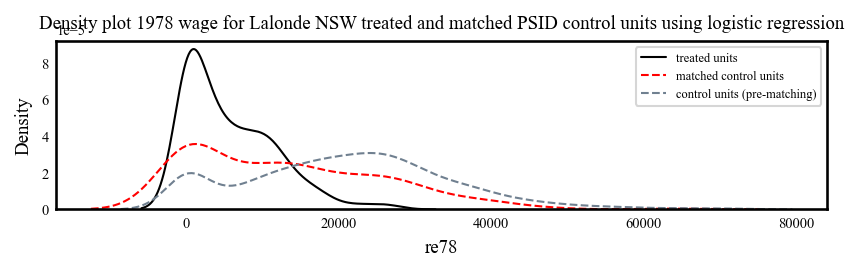

In [673]:
plt.figure()
plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in",x = "in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=3))
plt.rcParams.update(fontsizes.neurips2022())

plt.grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
plt.grid(color='white', axis='x')

# Density plots post-matching
sns.kdeplot(nsw_psid_ps_matched['re78'][nsw_psid_ps_matched['treat']==1.0],color = 'black',linewidth=1,label = 'treated units')
sns.kdeplot(nsw_psid_ps_matched['re78'][nsw_psid_ps_matched['treat']==0.0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units')
# Density plots pre-matching
sns.kdeplot(nsw_psid_ps_pre_matched['re78'][nsw_psid_ps_pre_matched['treat']==0.0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)')

plt.title('Density plot 1978 wage for Lalonde NSW treated and matched PSID control units using logistic regression')
plt.legend(fontsize=6,loc = 1)

<p> Estimate ATE </p>

### model (2) ; CART 

In [731]:
# import neccesary for CART 
from sklearn import tree           # for regression trees 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import graphviz                     # for plotting decision tree graphs

In [748]:
# read in data 
# experimental data 
nsw = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw_featureTransformed.csv")
nswre74 = pd.read_csv("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_featureTransformed.csv")

# non experimental data (cps)
cps1 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_featureTransformed.csv')
psid1 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_featureTransformed.csv')

del psid1['data_id']

# reset indexes
nsw_pd_df = nsw.reset_index(drop=True)
nswre74_pd_df = nswre74.reset_index(drop=True)
cps1 = cps1.reset_index(drop=True)
psid1 = psid1.reset_index(drop=True)


# ================================================ #

# Store outcome variable prior to feature scaling  

nsw_outcome = nsw[nsw_transformed_features['treat']==1].re78
nsw_re74_outcome = nswre74.re78
cps1_outcome = cps1.re78
psid1_outcome = psid1.re78


In [749]:
""" Select covariates for use in CART model """
sc = StandardScaler()
# ======== Lalonde (1986) data ======== #

# Select covariates for modelling 
nsw_subset1 = ['treat','age','education','black','hispanic','married','nodegree','lnre75','lnre78']
# Apply selection
nsw_lalonde = nsw[nsw_subset1]
cps_lalonde = cps1[nsw_subset1]
psid_lalonde = psid1[nsw_subset1]
# continuous  variables to be scaled 
lalonde_continuous_vars = ['age','education','lnre75','lnre78'] 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
nsw_lalonde[lalonde_continuous_vars] = sc.fit_transform(nsw_lalonde[lalonde_continuous_vars])
cps_lalonde[lalonde_continuous_vars] = sc.fit_transform(cps_lalonde[lalonde_continuous_vars])
psid_lalonde[lalonde_continuous_vars] = sc.fit_transform(psid_lalonde[lalonde_continuous_vars])

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Select covariates for modelling 
nswreDW_subset1 = ['treat','age','education','black','hispanic','married','nodegree','lnre74','lnre75','lnre78']
# Apply selection
nsw_dw = nswre74_pd_df[nswreDW_subset1]
cps_dw = cps1[nswreDW_subset1]
psid1_dw = psid1[nswreDW_subset1]
# continuous  variables to be scaled 
nswDW_continuous_vars = ['age','education','lnre74','lnre75','lnre78'] 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
nsw_dw[nswDW_continuous_vars] = sc.fit_transform(nsw_dw[nswDW_continuous_vars])
cps_dw[nswDW_continuous_vars] = sc.fit_transform(cps_dw[nswDW_continuous_vars])
psid1_dw[nswDW_continuous_vars] = sc.fit_transform(psid1_dw[nswDW_continuous_vars])

In [750]:
# Train test split 
# ======== Lalonde (1986) sub sample ======== #
nsw_lalonde = nsw_lalonde.sample(frac = 1,random_state=0) # Shuffle data 

# Define features and target 
FEATURES = nsw_lalonde.drop('treat', axis=1)
TARGET = nsw_lalonde.iloc[:,0]
# Train test split 
FEATURES_train, FEATURES_test, TARGET_train, TARGET_test = train_test_split(FEATURES, TARGET, test_size=0.3, random_state=42) 

# ======== Dehejia & Wahba (1999) sub sample ======== #
nsw_dw = nsw_dw.sample(frac = 1,random_state=0) # Shuffle data 
# Define features and target 
FEATURES_DW = nsw_dw.drop('treat', axis=1)
TARGET_DW = nsw_dw.iloc[:,0]
# Train test split 
FEATURES_DW_train, FEATURES_DW_test, TARGET_DW_train, TARGET_DW_test = train_test_split(FEATURES_DW, TARGET_DW, test_size=0.3, random_state=42) 


In [751]:
# Grid search 
tree_param = [{'criterion': ['entropy', 'gini'], 
               'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
               'max_leaf_nodes':list(range(0, 100)),
              'min_samples_leaf': [2, 3, 4]}]

grid_search_tree1 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=5)
grid_search_tree2 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=5)

In [752]:
grid_search_tree1.fit(FEATURES_train, TARGET_train)        # fit CART  - lalonde (1986) data
grid_search_tree2.fit(FEATURES_DW_train, TARGET_DW_train)  # fit CART  - dehejia & wahba (1999) subsample

Fitting 5 folds for each of 6600 candidates, totalling 33000 fits
Fitting 5 folds for each of 6600 candidates, totalling 33000 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                          'max_leaf_nodes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                             11, 12, 13, 14, 15, 16, 17, 18, 19,
                                             20, 21, 22, 23, 24, 25, 26, 27, 28,
                                             29, ...],
                          'min_samples_leaf': [2, 3, 4]}],
             verbose=1)

In [753]:
tree_predictions1 = grid_search_tree1.predict(FEATURES_test)    # predict CART   - lalonde (1986) data
tree_predictions2 = grid_search_tree2.predict(FEATURES_DW_test) # predict CART  - dehejia & wahba (1999) subsample

In [754]:
""" CART metrics """

# ======== Lalonde (1986) sample ======== #

print('--------------------- CART metrics ---------------------')
print('lalonde sample')

print(f'Accuracy : {metrics.accuracy_score(TARGET_test, tree_predictions1):.2f}')
print(f'Precision : {metrics.precision_score(TARGET_test, tree_predictions1):.2f}')
print(f'Recall : {metrics.recall_score(TARGET_test, tree_predictions1):.2f}')
print(f'MSE : {metrics.mean_squared_error(TARGET_test, tree_predictions1):.2f}')
print(f'f1 score : {metrics.f1_score(TARGET_test, tree_predictions1):.2f}')
print('____________________________________________________')

# ======== Dehejia & Wahba (1999) sub sample ======== #

print('dehejia & wahba sample')
print(f'Accuracy : {metrics.accuracy_score(TARGET_DW_test, tree_predictions2):.2f}')
print(f'Precision : {metrics.precision_score(TARGET_DW_test, tree_predictions2):.2f}')
print(f'Recall : {metrics.recall_score(TARGET_DW_test, tree_predictions2):.2f}')
print(f'MSE : {metrics.mean_squared_error(TARGET_DW_test, tree_predictions2):.2f}')
print(f'f1 score : {metrics.f1_score(TARGET_DW_test, tree_predictions2):.2f}')

print('____________________________________________________')

--------------------- CART metrics ---------------------
lalonde sample
Accuracy : 0.54
Precision : 0.36
Recall : 0.23
MSE : 0.46
f1 score : 0.28
____________________________________________________
dehejia & wahba sample
Accuracy : 0.57
Precision : 0.40
Recall : 0.26
MSE : 0.43
f1 score : 0.32
____________________________________________________


In [755]:
# Predict propensity scores on NSW , CPS and PSID 

# ============ Lalonde Subsample ============ # 

nsw_lalonde_ps_CARTmodel = propensity_score_funct(nsw_lalonde,grid_search_tree1)
nsw_lalonde_treated_ps_CARTmodel = nsw_lalonde_ps_CARTmodel[nsw_lalonde_ps_CARTmodel['treat'] == 1] # drop control units from lalonde dataset 

cps_lalonde_ps_CARTmodel = propensity_score_funct(cps_lalonde,grid_search_tree1)
psid_lalonde_ps_CARTmodel = propensity_score_funct(psid_lalonde,grid_search_tree1)

# Rejoin the outcome variable to dataframe with estimated propensity scores 
nsw_lalonde_treated_ps_CARTmodel_full = pd.merge(nsw_lalonde_treated_ps_CARTmodel, nsw_outcome, left_index=True, right_index=True)

cps_lalonde_ps_CARTmodel_full = pd.merge(cps_lalonde_ps_CARTmodel,cps1_outcome,left_index=True, right_index=True) # join cps data and outcome covariate for cps data
psid_lalonde_ps_CARTmodel_full = pd.merge(psid_lalonde_ps_CARTmodel,psid1_outcome,left_index=True, right_index=True) # join psid data and outcome covariate for psid data

# Combine treated units from lalonde sample with control units from comparions datasets 
quasi_data_nswCps_lalonde_ps = pd.concat([nsw_lalonde_treated_ps_CARTmodel_full,cps_lalonde_ps_CARTmodel_full],axis=0, ignore_index = True)
quasi_data_nswPsid_lalonde_ps = pd.concat([nsw_lalonde_treated_ps_CARTmodel_full,psid_lalonde_ps_CARTmodel_full],axis=0, ignore_index = True)

# ============ Dehejia & Wahba sub sample ============ # 

nsw_dw_ps_CARTmodel = propensity_score_funct(nsw_dw,grid_search_tree2)
nsw_treatedUnits_dw_ps_CARTmodel = nsw_dw_ps_CARTmodel[nsw_dw_ps_CARTmodel['treat'] == 1] # drop control units from lalonde dataset 

cps_dw_ps_CARTmodel = propensity_score_funct(cps_dw,grid_search_tree2)
psid_dw_ps_CARTmodel = propensity_score_funct(psid1_dw,grid_search_tree2)

# Rejoin the outcome variable to dataframe with estimated propensity scores 
nsw_dw_treatedUnits_ps_CARTmodel_full = pd.merge(nsw_dw_ps_CARTmodel, nsw_outcome, left_index=True, right_index=True)
cps_dw_ps_CARTmodel_full = pd.merge(cps_dw_ps_CARTmodel,cps1_outcome,left_index=True, right_index=True)
psid_dw_ps_CARTmodel_full = pd.merge(psid_dw_ps_CARTmodel,psid1_outcome,left_index=True, right_index=True)

# Combine treated units with control units 
quasi_data_nswCps_dw_ps = pd.concat([nsw_dw_treatedUnits_ps_CARTmodel_full,cps_dw_ps_CARTmodel_full],axis=0, ignore_index = True)
quasi_data_nswPsid_dw_ps = pd.concat([nsw_dw_treatedUnits_ps_CARTmodel_full,psid_dw_ps_CARTmodel_full],axis=0, ignore_index = True)





In [756]:
from causalml.match import NearestNeighborMatch, create_table_one

# ============ Lalonde Subsample ============ #  
caliper = np.std(quasi_data_nswCps_lalonde_ps.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 

# NSW and CPS comparison group 
nsw_lalonde_cps_ps_matched = psm.match(quasi_data_nswCps_lalonde_ps,'treat',['propensity_score'])
nsw_lalonde_cps_ps_pre_matched = pd.concat([nsw_lalonde_treated_ps_CARTmodel_full,cps_lalonde_ps_CARTmodel_full],axis=0,ignore_index=True)

# NSW and PSID comparison group 
nsw_lalonde_psid_ps_matched = psm.match(quasi_data_nswPsid_lalonde_ps,'treat',['propensity_score'])
nsw_lalonde_psid_ps_pre_matched = pd.concat([nsw_lalonde_treated_ps_CARTmodel_full,psid_ps_logitmodel_full],axis=0,ignore_index=True) # comparison before matchibg 

# ============ Dehejia & Wahba sub sample ============ # 

caliper = np.std(quasi_data_nswCps_dw_ps.propensity_score) * 0.25
psm = NearestNeighborMatch(replace=False,caliper= caliper,random_state=42) # Matching without replacement 

# NSW and CPS comparison group 
nsw_lalonde_cps_ps_matched = psm.match(quasi_data_nswCps_dw_ps,'treat',['propensity_score'])
nsw_lalonde_cps_ps_pre_matched = pd.concat([nsw_treatedUnits_dw_ps_CARTmodel,cps_dw_ps_CARTmodel_full],axis=0,ignore_index=True)

# NSW and PSID comparison group 
nsw_lalonde_psid_ps_matched = psm.match(quasi_data_nswPsid_dw_ps,'treat',['propensity_score'])
nsw_lalonde_psid_ps_pre_matched = pd.concat([nsw_treatedUnits_dw_ps_CARTmodel,psid_dw_ps_CARTmodel_full],axis=0,ignore_index=True) # comparison before matchibg 

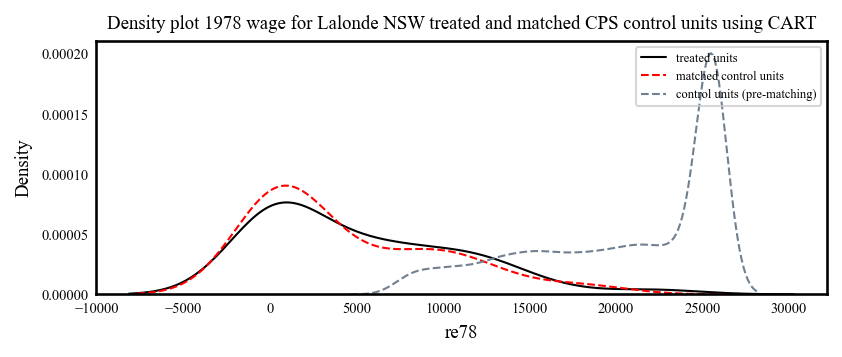

In [757]:
plt.figure()
plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in",x = "in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=3))
plt.rcParams.update(fontsizes.neurips2022())

plt.grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
plt.grid(color='white', axis='x')

# Density plots post-matching
sns.kdeplot(nsw_lalonde_cps_ps_matched['re78'][nsw_lalonde_cps_ps_matched['treat']==1],color = 'black',linewidth=1,label = 'treated units')
sns.kdeplot(nsw_lalonde_cps_ps_matched['re78'][nsw_lalonde_cps_ps_matched['treat']==0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units')
# Density plots pre-matching
sns.kdeplot(nsw_lalonde_cps_ps_pre_matched['re78'][nsw_lalonde_cps_ps_pre_matched['treat']==0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)')

plt.title('Density plot 1978 wage for Lalonde NSW treated and matched CPS control units using CART')
plt.legend(fontsize=6,loc = 1)

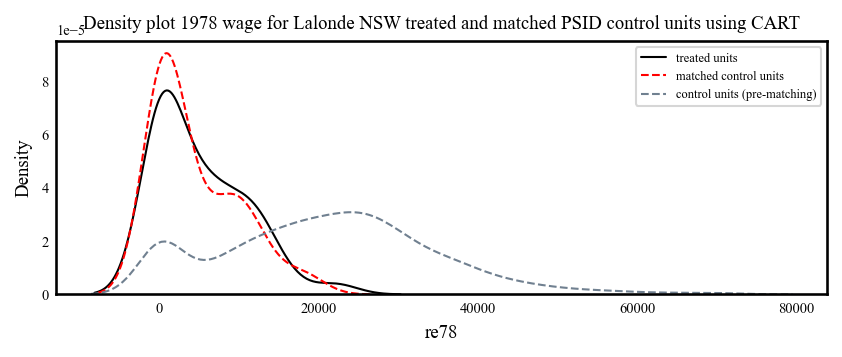

In [758]:
plt.figure()
plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in",x = "in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=3))
plt.rcParams.update(fontsizes.neurips2022())

plt.grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
plt.grid(color='white', axis='x')

# Density plots post-matching
sns.kdeplot(nsw_lalonde_psid_ps_matched['re78'][nsw_lalonde_psid_ps_matched['treat']==1.0],color = 'black',linewidth=1,label = 'treated units')
sns.kdeplot(nsw_lalonde_psid_ps_matched['re78'][nsw_lalonde_psid_ps_matched['treat']==0.0],color = 'red',linewidth=1,linestyle = 'dashed',label = 'matched control units')
# Density plots pre-matching
sns.kdeplot(nsw_lalonde_psid_ps_pre_matched['re78'][nsw_lalonde_psid_ps_pre_matched['treat']==0.0],color = 'slategrey',linewidth=1,linestyle = 'dashed',label = 'control units (pre-matching)')

plt.title('Density plot 1978 wage for Lalonde NSW treated and matched PSID control units using CART')
plt.legend(fontsize=6,loc = 1)

### model (3) ; Random Forest

### model (4) ; Boosted Trees

### model (5) - artifical neural network

#### define ANN class 

In [46]:
class twoLayerNN(nn.Module):
    def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2):
        super(twoLayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)

    # Forward propogation method
    def forward(self, inputs):
        x = self.relu_activation(self.input_layer(inputs))
        x = self.batchnorm1(x)
        x = self.relu_activation(self.hidden_layer1(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.output_activation(self.out_layer(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


<p> test distributions</p>

<p> plot distribtions of key variables pre and post matching </p>

(-10000.0, 45000.0)

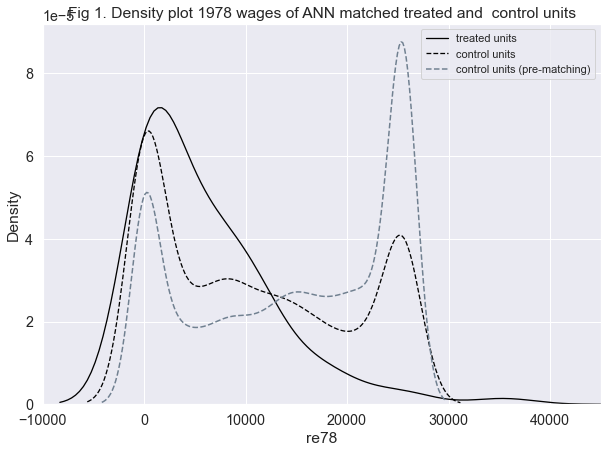

In [50]:
plt.figure(figsize=(10,7))
# Density plots post-matching
sns.kdeplot(matched_df['re78'][matched_df['treat']==1],color = 'black',linewidth=1.3,label = 'treated units')
sns.kdeplot(matched_df['re78'][matched_df['treat']==0],color = 'black',linewidth=1.3,linestyle = 'dashed',label = 'control units')
plt.title('Fig 1. Density plot 1978 wages of ANN matched treated and  control units')
# Density plots pre-matching
sns.kdeplot(before_matched_df['re78'][before_matched_df['treat']==0],color = 'slategrey',linewidth=1.5,linestyle = 'dashed',label = 'control units (pre-matching)')

plt.legend(fontsize=11,loc = 1)
plt.xlim([-10000, 45000])



(2.0, 21.0)

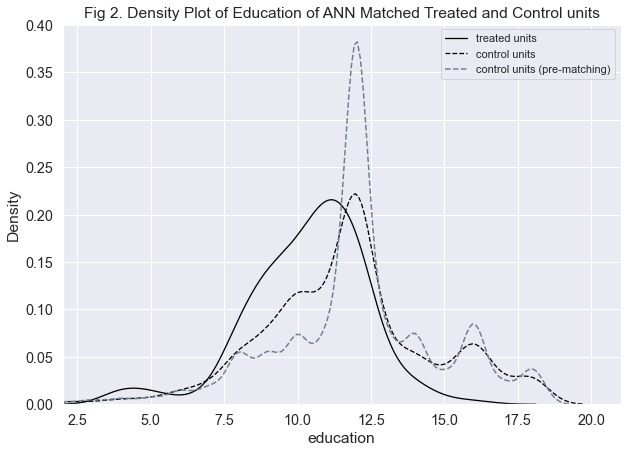

In [51]:
plt.figure(figsize=(10,7))
# Density plots post-matching
sns.kdeplot(matched_df['education'][matched_df['treat']==1],color = 'black',linewidth=1.3,label = 'treated units')
sns.kdeplot(matched_df['education'][matched_df['treat']==0],color = 'black',linewidth=1.3,linestyle = 'dashed',label = 'control units')
sns.kdeplot(before_matched_df['education'][before_matched_df['treat']==0],color = 'slategrey',linewidth=1.5,linestyle = 'dashed',label = 'control units (pre-matching)')
plt.title('Fig 2. Density Plot of Education of ANN Matched Treated and Control units')
plt.legend(fontsize=11,loc = 1)
plt.xlim([2, 21])

### Matching 2 - logistic regression